In [3]:
import cobra
import gurobipy as grb
import matplotlib.pyplot as plt
import pandas as pd
import mptool as mpt
import networkx as nx
import numpy as np
import random
import seaborn as sns
import string

from collections import defaultdict
from fastcluster import linkage
from importlib import reload
from itertools import chain, permutations
from matplotlib import rcParams
from matplotlib.colors import LinearSegmentedColormap
from matplotlib_venn import venn2, venn3
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from os.path import join
from scipy.stats import pearsonr, spearmanr

from functions import *

%matplotlib inline

rcParams['mathtext.fontset'] = 'custom'
rcParams['mathtext.rm'] = 'Arial'
rcParams['mathtext.it'] = 'Arial:italic'
rcParams['mathtext.bf'] = 'Arial:bold'

plot_dir = 'results/figures'

sns.set(style='ticks', font_scale=1.5)

In [4]:
# Reload functions (if modified)
import functions
reload(functions)
from functions import *

In [5]:
# Choose model ID
model_id = 'e_coli_core'
# model_id = 'iIT341_ecm_minII'
# model_id = 'iJR904_ecm'
model_id

'e_coli_core'

In [6]:
# Define orders

matrix_order = ['full', 'unique', 'growth']

pathway_order = ['efm', 'ecm', 'efp', 'mp']

if model_id.startswith('iIT341'):
    pathway_order = ['ecm', 'efp', 'mp']
elif model_id.startswith('iJR904'):
    pathway_order = ['mp']

pathway_order

['efm', 'ecm', 'efp', 'mp']

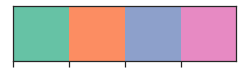

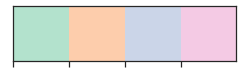

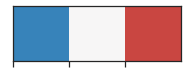

In [7]:
# Define colors

palette_order = ['efm', 'efp', 'ecm', 'mp']

pathway_palette = dict(zip(palette_order, sns.color_palette('Set2', len(palette_order))))
sns.palplot(pathway_palette.values())

pathway_palette_pale = dict(zip(palette_order, sns.color_palette('Pastel2', len(palette_order))))
sns.palplot(pathway_palette_pale.values())

n = 5
cmap = sns.color_palette('RdBu_r', n)[0:n:int(n / 2)]
sns.palplot(cmap)

In [8]:
# Load model
model = cobra.io.read_sbml_model('models/' + model_id + '.xml')
model

Set parameter Username
Academic license - for non-commercial use only - expires 2024-09-06


<Model e_coli_core at 0x207da2ae4c0>

In [9]:
# Define objective
objective = model.reactions[[r.objective_coefficient for r in model.reactions].index(True)].id
objective

'BIOMASS_Ecoli_core_w_GAM'

In [10]:
# Check model boundary
for r in model.boundary:
    print(r, r.bounds)

EX_ac_e: ac_e -->  (0.0, 1000.0)
EX_acald_e: acald_e -->  (0.0, 1000.0)
EX_akg_e: akg_e -->  (0.0, 1000.0)
EX_co2_e: co2_e <=>  (-1000.0, 1000.0)
EX_etoh_e: etoh_e -->  (0.0, 1000.0)
EX_for_e: for_e -->  (0.0, 1000.0)
EX_fru_e: fru_e -->  (0.0, 1000.0)
EX_fum_e: fum_e -->  (0.0, 1000.0)
EX_glc__D_e: glc__D_e <=>  (-10.0, 1000.0)
EX_gln__L_e: gln__L_e -->  (0.0, 1000.0)
EX_glu__L_e: glu__L_e -->  (0.0, 1000.0)
EX_h_e: h_e <=>  (-1000.0, 1000.0)
EX_h2o_e: h2o_e <=>  (-1000.0, 1000.0)
EX_lac__D_e: lac__D_e -->  (0.0, 1000.0)
EX_mal__L_e: mal__L_e -->  (0.0, 1000.0)
EX_nh4_e: nh4_e <=>  (-1000.0, 1000.0)
EX_o2_e: o2_e <=>  (-1000.0, 1000.0)
EX_pi_e: pi_e <=>  (-1000.0, 1000.0)
EX_pyr_e: pyr_e -->  (0.0, 1000.0)
EX_succ_e: succ_e -->  (0.0, 1000.0)


In [11]:
# Set model boundary
bound = 1000
for r in model.boundary:
    r.bounds = bound * np.sign(r.bounds)
    print(r, r.bounds)

EX_ac_e: ac_e -->  (0.0, 1000.0)
EX_acald_e: acald_e -->  (0.0, 1000.0)
EX_akg_e: akg_e -->  (0.0, 1000.0)
EX_co2_e: co2_e <=>  (-1000.0, 1000.0)
EX_etoh_e: etoh_e -->  (0.0, 1000.0)
EX_for_e: for_e -->  (0.0, 1000.0)
EX_fru_e: fru_e -->  (0.0, 1000.0)
EX_fum_e: fum_e -->  (0.0, 1000.0)
EX_glc__D_e: glc__D_e <=>  (-1000.0, 1000.0)
EX_gln__L_e: gln__L_e -->  (0.0, 1000.0)
EX_glu__L_e: glu__L_e -->  (0.0, 1000.0)
EX_h_e: h_e <=>  (-1000.0, 1000.0)
EX_h2o_e: h2o_e <=>  (-1000.0, 1000.0)
EX_lac__D_e: lac__D_e -->  (0.0, 1000.0)
EX_mal__L_e: mal__L_e -->  (0.0, 1000.0)
EX_nh4_e: nh4_e <=>  (-1000.0, 1000.0)
EX_o2_e: o2_e <=>  (-1000.0, 1000.0)
EX_pi_e: pi_e <=>  (-1000.0, 1000.0)
EX_pyr_e: pyr_e -->  (0.0, 1000.0)
EX_succ_e: succ_e -->  (0.0, 1000.0)


In [12]:
# Turn off ATPM (does not seem to affect growth-supporting pathways)
if model_id == 'e_coli_core':
    model.reactions.ATPM.bounds = 0, 0

In [13]:
# Define metabolite names

d = {m.id: m.name for m in set(r.reactants[0] for r in model.boundary)}

d['fe3_e'] = 'Iron'
d['h2o_e'] = 'Water'
d['urea_e'] = 'Urea'
d['thymd_e'] = 'Thymidine'
d['fe2_e'] = 'Iron'
d['pheme_e'] = 'Protoheme'
d['co2_e'] = 'CO$_2$'
d['o2_e'] = 'Oxygen'
d['nmn_e'] = 'NMN'
d['orot_e'] = 'Orotate'
d['melib_e'] = 'Melibiose'
d['sucr_e'] = 'Sucrose'
d['malt_e'] = 'Maltose'
d['glyclt_e'] = 'Glycolate'
d['chol_e'] = 'Choline'
d['malttr_e'] = 'Maltotriose'
d['taur_e'] = 'Taurine'
d['amp_e'] = 'AMP'
d['lcts_e'] = 'Lactose'
d['lac__D_e'] = 'Lactate'

for x in list(d.keys()):
    d[x + '_rev'] = d[x]
    
met_names = d
met_names

{'glc__D_e': 'D-Glucose',
 'acald_e': 'Acetaldehyde',
 'nh4_e': 'Ammonium',
 'co2_e': 'CO$_2$',
 'etoh_e': 'Ethanol',
 'lac__D_e': 'Lactate',
 'succ_e': 'Succinate',
 'h2o_e': 'Water',
 'gln__L_e': 'L-Glutamine',
 'mal__L_e': 'L-Malate',
 'akg_e': '2-Oxoglutarate',
 'o2_e': 'Oxygen',
 'fru_e': 'D-Fructose',
 'glu__L_e': 'L-Glutamate',
 'fum_e': 'Fumarate',
 'pi_e': 'Phosphate',
 'ac_e': 'Acetate',
 'for_e': 'Formate',
 'h_e': 'H+',
 'pyr_e': 'Pyruvate',
 'fe3_e': 'Iron',
 'urea_e': 'Urea',
 'thymd_e': 'Thymidine',
 'fe2_e': 'Iron',
 'pheme_e': 'Protoheme',
 'nmn_e': 'NMN',
 'orot_e': 'Orotate',
 'melib_e': 'Melibiose',
 'sucr_e': 'Sucrose',
 'malt_e': 'Maltose',
 'glyclt_e': 'Glycolate',
 'chol_e': 'Choline',
 'malttr_e': 'Maltotriose',
 'taur_e': 'Taurine',
 'amp_e': 'AMP',
 'lcts_e': 'Lactose',
 'glc__D_e_rev': 'D-Glucose',
 'acald_e_rev': 'Acetaldehyde',
 'nh4_e_rev': 'Ammonium',
 'co2_e_rev': 'CO$_2$',
 'etoh_e_rev': 'Ethanol',
 'lac__D_e_rev': 'Lactate',
 'succ_e_rev': 'Succinate'

In [14]:
# Load or enumerate EFMs

load_efms = True

if 'efm' in pathway_order:
    if load_efms:
        efm_df = pd.read_csv('results/efm/' + model.id + '.csv', index_col=0)
    else:
        # Reverse irreversible reactions defined for negative flux from right to left
        reactions = []
        for r in model.reactions:
            if r.lower_bound and r.upper_bound <= 0:
                reactions.append(r)
        mpt.make_irreversible(model, reactions)

        # Enumerate EFMs
        efm_df = enumerate_efms(model)

        # Export to CSV
        efm_df.to_csv('results/efm/' + model.id + '.csv')

    efm_dfs = get_efm_dfs(efm_df, objective=objective, subset=[r.id for r in model.boundary])
    
    # Get unique exchange patterns of EFMs
    efms = get_sets(efm_dfs['growth'])

    for k in matrix_order:
        print(k, efm_dfs[k].shape)
    print(len(efms))

full (100274, 87)
unique (1004, 17)
growth (738, 16)
738


c:\Users\ylwe\OneDrive - Norwegian University of Life Sciences\Documents\Digisal\code\masteroppgave-pathway-analysis\functions.py:147: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  df = df[df[objective] > tol].drop(objective, 1)


In [15]:
# Load ECMs

if 'ecm' in pathway_order:
    if model_id == 'e_coli_core':
        ecm_df = pd.read_csv('results/ecm/e_coli_core.csv')
    elif model_id == 'iIT341_ecm_minII':
        ecm_df = pd.read_csv('results/ecm/iIT_minII.csv')
    elif model_id == 'iJR904_ecm':
        ecm_df = pd.read_csv('results/ecm/iJR_hideallexceptglco2biomass.csv')

    # Get ECMs
    ecm_dfs = get_ecm_dfs(ecm_df)
    ecms = get_sets(ecm_dfs['growth'])

    for k in matrix_order:
        print(k, ecm_dfs[k].shape)
    print(len(ecms))

full (689, 17)
unique (419, 17)
growth (346, 16)
346


c:\Users\ylwe\OneDrive - Norwegian University of Life Sciences\Documents\Digisal\code\masteroppgave-pathway-analysis\functions.py:204: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  df = df[df[objective] > tol].drop(objective, 1)


In [16]:
# Get EFPs from EFMs (or ECMs!)

load_efps = model_id.startswith('iIT341')

if 'efp' in pathway_order:
    if load_efps:
        # Load full EFP data frame
        efp_df = pd.read_csv('results/efp/' + model.id + '.csv', index_col=0)
        # Get all EFP data frames
        efp_dfs = get_efp_dfs(efp_df, objective='objective')
    else:
        if 'efm' in pathway_order:
            # Get EFPs from EFMs
            efp_dfs = get_efp_dfs(efm_dfs['unique'], objective=objective)
        elif 'ecm' in pathway_order:
            # Get EFPs from ECMs
            efp_dfs = get_efp_dfs(ecm_dfs['unique'], objective='objective')

        # Export to CSV
        efp_dfs['full'].to_csv('results/efp/' + model.id + '.csv')
    
    # Get EFPs
    efps = get_sets(efp_dfs['growth'])
    
    for k in matrix_order:
        print(k, efp_dfs[k].shape)
    print(len(efps))

full (118, 17)
unique (118, 17)
growth (63, 16)
63


c:\Users\ylwe\OneDrive - Norwegian University of Life Sciences\Documents\Digisal\code\masteroppgave-pathway-analysis\functions.py:176: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  df = df[df[objective] > tol].drop(objective, 1)


In [17]:
# Load or enumerate MPs

load_mps = True

if 'mp' in pathway_order:
    if load_mps:
        # Load MPs
        if model_id == 'e_coli_core':
            mps = mpt.load_sets('results/mp/e_coli_core_20230119_13242764666_complete_mps.csv')
        elif model_id == 'iIT341_ecm_minII':
            mps = mpt.load_sets('results/mp/iIT341_20221126_0145381771426_complete_mps.csv')
        elif model_id == 'iJR904_ecm':
            mps = mpt.load_sets('results/mp/iJR904_20230404_1753450803406_complete_mps.csv')
        else:
            raise ValueError('Unsupported model')
    else:
        # Enumerate MPs

        min_growth = 1e-4

        with model as m:
            if model_id == 'e_coli_core':
                model.reactions.BIOMASS_Ecoli_core_w_GAM.lower_bound = min_growth
            elif model_id == 'iIT341_ecm_minII':
                m.reactions.BIOMASS_HP_published.lower_bound = min_growth
            elif model_id == 'iJR904_ecm':
                model.reactions.BIOMASS_Ecoli.lower_bound = min_growth

            subset = set(r.id for r in mpt.make_irreversible(m, m.boundary))

            mps, mcs, complete = mpt.find_mps(
                m,
                subset=subset,
                method='iterative',
                graph=True,
                random=False,
                bounds={},
                tol=1e-9,
                inf=1000,
                threads=0,
                max_mps=0,
                max_t=0,
                verbose=True,
                export=True
            )
    
    # Get MP data frame and MPs
    mp_df, mps = get_mp_df_and_mps(mps)

    print(mp_df.shape)
    print(len(mps))

(34, 16)
34


In [18]:
# Organize data frames and pathways

pathway_dfs = {}
pathways = {}

if 'efm' in pathway_order:
    pathway_dfs['efm'] = efm_dfs
    pathways['efm'] = efms
if 'efp' in pathway_order:
    pathway_dfs['efp'] = efp_dfs
    pathways['efp'] = efps
if 'ecm' in pathway_order:
    pathway_dfs['ecm'] = ecm_dfs
    pathways['ecm'] = ecms
if 'mp' in pathway_order:
    pathway_dfs['mp'] = dict(zip(matrix_order, [mp_df] * 3))
    pathways['mp'] = mps

pathway_dfs, pathways

({'efm': {'full':                 PFK          PFL          PGI          PGK        PGL  ACALD  \
   0        159.166898     0.000000    36.005125   -73.260111   4.486704    0.0   
   1        245.038522     0.000000    50.832421  -103.429409   6.334376    0.0   
   2         85.677552    73.263199    77.205710  -156.175987   6.334376    0.0   
   3       1332.095588  1164.345588  1226.116422 -2479.879902  99.246324    0.0   
   4        269.437256   211.742089   227.034460  -451.678370  13.184005    0.0   
   ...             ...          ...          ...          ...        ...    ...   
   100269     2.000000     0.000000     0.000000    -5.000000   3.000000   -5.0   
   100270     2.000000     0.000000     0.000000    -5.000000   3.000000   -5.0   
   100271     2.000000     0.000000     0.000000    -5.000000   3.000000   -5.0   
   100272     2.000000     0.000000     0.000000    -5.000000   3.000000   -5.0   
   100273     2.000000     0.000000     0.000000    -5.000000   3.000000

In [19]:
# Count pathways

d = defaultdict(list)

for x in pathway_order:
    for y in matrix_order:
        d['pathway'].append(x)
        d['matrix'].append(y)
        d['cnt'].append(len(pathway_dfs[x][y]))

cnt_df = pd.DataFrame(d)

cnt_df.to_csv('results/pathway_counts_' + model_id + '.csv')

cnt_df

pathway  matrix     cnt
0      efm    full  100274
1      efm  unique    1004
2      efm  growth     738
3      ecm    full     689
4      ecm  unique     419
5      ecm  growth     346
6      efp    full     118
7      efp  unique     118
8      efp  growth      63
9       mp    full      34
10      mp  unique      34
11      mp  growth      34

In [20]:
# Try to load data frame with (exchange) pathway statistics
try:
    stat_df = pd.read_csv('results/pathway_data_' + model_id + '.csv', index_col=0)
except FileNotFoundError:
    stat_df = pd.DataFrame()
stat_df

pathway  number  length  consumed  produced  efm_equal  efm_subsets  \
0        efm       0       7         4         3          1            1   
1        efm       1       9         4         5          1            5   
2        efm       2       8         4         4          1            1   
3        efm       3       8         4         4          1            2   
4        efm       4       8         4         4          1            2   
...      ...     ...     ...       ...       ...        ...          ...   
1176      mp      29       8         4         4          1            1   
1177      mp      30       8         3         5          1            1   
1178      mp      31       8         4         4          1            1   
1179      mp      32       8         3         5          1            1   
1180      mp      33       7         4         3          1            1   

      efm_supersets  efp_equal  efp_subsets  efp_supersets  ecm_equal  \
0               103          1            1              1          1   
1                13          0            2              0          1   
2                84          1            1              2          1   
3                47          0            1              0          1   
4                23          0            1              0          1   
...             ...        ...          ...            ...        ...   
1176             27          1            1              1          1   
1177             25          1            1              2          1   
1178             32          1            1              1          1   
1179             13          1            1              2          1   
1180            182          1            1              1          1   

      ecm_subsets  ecm_supersets  mp_equal  mp_subsets  mp_supersets  
0               1             42         1           1             1  
1               5              4         0           2             0  
2               1             29         1           1             1  
3               2             19         0           1             0  
4               2              7         0           1             0  
...           ...            ...       ...         ...           ...  
1176            1             13         1           1             1  
1177            1              9         1           1             1  
1178            1             15         1           1             1  
1179            1              5         1           1             1  
1180            1             48         1           1             1  

[1181 rows x 17 columns]

In [21]:
# Build data frame with (exchange) pathway statistics

compare_pathways = False

if stat_df.empty:
    d = defaultdict(list)

    for x in pathway_order:
        d['pathway'].extend([x] * len(pathways[x]))
        d['number'].extend(list(range(len(pathways[x]))))
        d['length'].extend([len(p) for p in pathways[x]])
        d['consumed'].extend(list((pathway_dfs[x]['growth'] < 0).sum(1)))
        d['produced'].extend(list((pathway_dfs[x]['growth'] > 0).sum(1)))

    stat_df = pd.DataFrame(d)
    stat_df.to_csv('results/pathway_data_' + model_id + '.csv')
    
    compare_pathways = True

stat_df

pathway  number  length  consumed  produced  efm_equal  efm_subsets  \
0        efm       0       7         4         3          1            1   
1        efm       1       9         4         5          1            5   
2        efm       2       8         4         4          1            1   
3        efm       3       8         4         4          1            2   
4        efm       4       8         4         4          1            2   
...      ...     ...     ...       ...       ...        ...          ...   
1176      mp      29       8         4         4          1            1   
1177      mp      30       8         3         5          1            1   
1178      mp      31       8         4         4          1            1   
1179      mp      32       8         3         5          1            1   
1180      mp      33       7         4         3          1            1   

      efm_supersets  efp_equal  efp_subsets  efp_supersets  ecm_equal  \
0               103          1            1              1          1   
1                13          0            2              0          1   
2                84          1            1              2          1   
3                47          0            1              0          1   
4                23          0            1              0          1   
...             ...        ...          ...            ...        ...   
1176             27          1            1              1          1   
1177             25          1            1              2          1   
1178             32          1            1              1          1   
1179             13          1            1              2          1   
1180            182          1            1              1          1   

      ecm_subsets  ecm_supersets  mp_equal  mp_subsets  mp_supersets  
0               1             42         1           1             1  
1               5              4         0           2             0  
2               1             29         1           1             1  
3               2             19         0           1             0  
4               2              7         0           1             0  
...           ...            ...       ...         ...           ...  
1176            1             13         1           1             1  
1177            1              9         1           1             1  
1178            1             15         1           1             1  
1179            1              5         1           1             1  
1180            1             48         1           1             1  

[1181 rows x 17 columns]

In [22]:
# Count pathways that are equal, subsets, and supersets

if compare_pathways:

    d = defaultdict(list)

    for i, row in stat_df.iterrows():
        if not i % 1000:
            print(i)
        p1 = pathways[row.pathway][row.number]
        for x in pathways:
            d[x + '_equal'].append(np.sum([p1 == p2 for p2 in pathways[x]]))
            d[x + '_subsets'].append(np.sum([p1 >= p2 for p2 in pathways[x]]))
            d[x + '_supersets'].append(np.sum([p1 <= p2 for p2 in pathways[x]]))

    for k, l in d.items():
        stat_df[k] = l

    stat_df.to_csv('results/pathway_data_' + model_id + '.csv')
    
stat_df

pathway  number  length  consumed  produced  efm_equal  efm_subsets  \
0        efm       0       7         4         3          1            1   
1        efm       1       9         4         5          1            5   
2        efm       2       8         4         4          1            1   
3        efm       3       8         4         4          1            2   
4        efm       4       8         4         4          1            2   
...      ...     ...     ...       ...       ...        ...          ...   
1176      mp      29       8         4         4          1            1   
1177      mp      30       8         3         5          1            1   
1178      mp      31       8         4         4          1            1   
1179      mp      32       8         3         5          1            1   
1180      mp      33       7         4         3          1            1   

      efm_supersets  efp_equal  efp_subsets  efp_supersets  ecm_equal  \
0               103          1            1              1          1   
1                13          0            2              0          1   
2                84          1            1              2          1   
3                47          0            1              0          1   
4                23          0            1              0          1   
...             ...        ...          ...            ...        ...   
1176             27          1            1              1          1   
1177             25          1            1              2          1   
1178             32          1            1              1          1   
1179             13          1            1              2          1   
1180            182          1            1              1          1   

      ecm_subsets  ecm_supersets  mp_equal  mp_subsets  mp_supersets  
0               1             42         1           1             1  
1               5              4         0           2             0  
2               1             29         1           1             1  
3               2             19         0           1             0  
4               2              7         0           1             0  
...           ...            ...       ...         ...           ...  
1176            1             13         1           1             1  
1177            1              9         1           1             1  
1178            1             15         1           1             1  
1179            1              5         1           1             1  
1180            1             48         1           1             1  

[1181 rows x 17 columns]

In [23]:
# Compute metabolite uptake and secretion frequencies

frac_df = pd.DataFrame()

for pathway in pathway_order:
        
    u = defaultdict(float)
    s = defaultdict(float)
    d = s
        
    for p in pathways[pathway]:
        for x in p:
            if x.endswith('_rev'):
                x = x[:-4]
                d = u
            else:
                d = s
            met_name = met_names[x]                    
            d[met_name] += 1 / len(pathways[pathway])

    df1, df2 = pd.DataFrame({'secretion': s}), -pd.DataFrame({'uptake': u})
    df = pd.concat([df1, df2], 1).fillna(0).sort_index()
    
    df = df.abs().assign(metabolite=df.index).reset_index(drop=True).melt(var_name='direction', id_vars='metabolite', value_name='fraction')
    df['pathway'] = pathway
    
    frac_df = pd.concat([frac_df, df]).reset_index(drop=True)
      
frac_df

C:\NMBU\TEMP\ipykernel_5828\4249264240.py:22: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only.
  df = pd.concat([df1, df2], 1).fillna(0).sort_index()
C:\NMBU\TEMP\ipykernel_5828\4249264240.py:22: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only.
  df = pd.concat([df1, df2], 1).fillna(0).sort_index()
C:\NMBU\TEMP\ipykernel_5828\4249264240.py:22: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only.
  df = pd.concat([df1, df2], 1).fillna(0).sort_index()
C:\NMBU\TEMP\ipykernel_5828\4249264240.py:22: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only.
  df = pd.concat([df1, df2], 1).fillna(0).sort_index()


metabolite  direction  fraction pathway
0    2-Oxoglutarate  secretion  0.386179     efm
1      Acetaldehyde  secretion  0.237127     efm
2           Acetate  secretion  0.269648     efm
3          Ammonium  secretion  0.000000     efm
4            CO$_2$  secretion  0.292683     efm
..              ...        ...       ...     ...
123          Oxygen     uptake  0.294118      mp
124       Phosphate     uptake  1.000000      mp
125        Pyruvate     uptake  0.000000      mp
126       Succinate     uptake  0.000000      mp
127           Water     uptake  0.058824      mp

[128 rows x 4 columns]

In [24]:
# Compute pairwise metabolite uptake and secretion frequencies

frac_pair_dfs = defaultdict(dict)

for pathway in pathway_order:
    print(pathway)

    d = defaultdict(float)

    for p in pathways[pathway]:
        for x in permutations(p, 2):
            d[x] += 1 / len(pathways[pathway])

    df = pd.DataFrame()
    for x, c in d.items():
        df.loc[x[0], x[1]] = c
    df = df.fillna(0).sort_index(0).sort_index(1)
    for ax in (0, 1):
        df = df.sort_index(ax, ascending=True, key=lambda s: pd.Series(met_names[y] + y.replace('_rev', '').replace('_gen', '_com')[-3:] for y in s)) 
    np.fill_diagonal(df.values, 1)

    frac_pair_dfs[pathway] = df

    print(df.shape)
    print()

C:\NMBU\TEMP\ipykernel_5828\2952214193.py:17: FutureWarning: In a future version of pandas all arguments of DataFrame.sort_index will be keyword-only.
  df = df.fillna(0).sort_index(0).sort_index(1)
C:\NMBU\TEMP\ipykernel_5828\2952214193.py:19: FutureWarning: In a future version of pandas all arguments of DataFrame.sort_index will be keyword-only.
  df = df.sort_index(ax, ascending=True, key=lambda s: pd.Series(met_names[y] + y.replace('_rev', '').replace('_gen', '_com')[-3:] for y in s))
C:\NMBU\TEMP\ipykernel_5828\2952214193.py:17: FutureWarning: In a future version of pandas all arguments of DataFrame.sort_index will be keyword-only.
  df = df.fillna(0).sort_index(0).sort_index(1)
C:\NMBU\TEMP\ipykernel_5828\2952214193.py:19: FutureWarning: In a future version of pandas all arguments of DataFrame.sort_index will be keyword-only.
  df = df.sort_index(ax, ascending=True, key=lambda s: pd.Series(met_names[y] + y.replace('_rev', '').replace('_gen', '_com')[-3:] for y in s))


efm
(18, 18)

ecm
(18, 18)

efp
(18, 18)

mp
(18, 18)



C:\NMBU\TEMP\ipykernel_5828\2952214193.py:17: FutureWarning: In a future version of pandas all arguments of DataFrame.sort_index will be keyword-only.
  df = df.fillna(0).sort_index(0).sort_index(1)
C:\NMBU\TEMP\ipykernel_5828\2952214193.py:19: FutureWarning: In a future version of pandas all arguments of DataFrame.sort_index will be keyword-only.
  df = df.sort_index(ax, ascending=True, key=lambda s: pd.Series(met_names[y] + y.replace('_rev', '').replace('_gen', '_com')[-3:] for y in s))
C:\NMBU\TEMP\ipykernel_5828\2952214193.py:17: FutureWarning: In a future version of pandas all arguments of DataFrame.sort_index will be keyword-only.
  df = df.fillna(0).sort_index(0).sort_index(1)
C:\NMBU\TEMP\ipykernel_5828\2952214193.py:19: FutureWarning: In a future version of pandas all arguments of DataFrame.sort_index will be keyword-only.
  df = df.sort_index(ax, ascending=True, key=lambda s: pd.Series(met_names[y] + y.replace('_rev', '').replace('_gen', '_com')[-3:] for y in s))


In [25]:
# Compute differences in metabolite uptake and secretion frequencies

d = defaultdict(list)

for l, df in frac_df.groupby(['metabolite', 'direction']):
    d['metabolite'].append(l[0])
    d['direction'].append(l[1])
    
    if 'ecm' in pathway_order:
        x = df[df.pathway == 'ecm'].fraction.iloc[0] - df[df.pathway == 'mp'].fraction.iloc[0]
        d['ecm_difference'].append(x)
        if x < 0:
            d['ecm_smallest'].append('mp')
        elif x > 0:
            d['ecm_smallest'].append('ecm')
        else:
            d['ecm_smallest'].append(np.nan)
    
    if 'efp' in pathway_order:
        x = df[df.pathway == 'efp'].fraction.iloc[0] - df[df.pathway == 'mp'].fraction.iloc[0]
        d['efp_difference'].append(x)
        if x < 0:
            d['efp_smallest'].append('mp')
        elif x > 0:
            d['efp_smallest'].append('efp')
        else:
            d['efp_smallest'].append(np.nan)

diff_df = pd.DataFrame(d)
        
diff_df

metabolite  direction  ecm_difference ecm_smallest  efp_difference  \
0   2-Oxoglutarate  secretion    1.322679e-01          ecm    6.395892e-02   
1   2-Oxoglutarate     uptake    0.000000e+00          NaN    0.000000e+00   
2     Acetaldehyde  secretion    2.295138e-02          ecm    1.400560e-02   
3     Acetaldehyde     uptake    0.000000e+00          NaN    0.000000e+00   
4          Acetate  secretion   -1.853111e-02           mp    5.042017e-02   
5          Acetate     uptake    0.000000e+00          NaN    0.000000e+00   
6         Ammonium  secretion    0.000000e+00          NaN    0.000000e+00   
7         Ammonium     uptake    6.661338e-15          ecm   -1.776357e-15   
8           CO$_2$  secretion    2.186331e-01          ecm    2.054155e-02   
9           CO$_2$     uptake    1.207072e-01          ecm    3.179272e-01   
10       D-Glucose  secretion    0.000000e+00          NaN    0.000000e+00   
11       D-Glucose     uptake    6.661338e-15          ecm   -1.776357e-15   
12         Ethanol  secretion    2.499150e-02          ecm    1.260504e-02   
13         Ethanol     uptake    0.000000e+00          NaN    0.000000e+00   
14         Formate  secretion   -7.990479e-03           mp    9.477124e-02   
15         Formate     uptake    0.000000e+00          NaN    0.000000e+00   
16              H+  secretion    6.661338e-15          ecm   -1.776357e-15   
17              H+     uptake    0.000000e+00          NaN    0.000000e+00   
18     L-Glutamate  secretion    9.044543e-02          ecm    4.108310e-02   
19     L-Glutamate     uptake    0.000000e+00          NaN    0.000000e+00   
20         Lactate  secretion    3.451207e-02          ecm    1.400560e-02   
21         Lactate     uptake    0.000000e+00          NaN    0.000000e+00   
22          Oxygen  secretion    0.000000e+00          NaN    0.000000e+00   
23          Oxygen     uptake    2.029922e-01          ecm   -4.014939e-02   
24       Phosphate  secretion    0.000000e+00          NaN    0.000000e+00   
25       Phosphate     uptake    6.661338e-15          ecm   -1.776357e-15   
26        Pyruvate  secretion    5.525332e-02          ecm    2.754435e-02   
27        Pyruvate     uptake    0.000000e+00          NaN    0.000000e+00   
28       Succinate  secretion    2.704862e-01          ecm   -1.083100e-01   
29       Succinate     uptake    0.000000e+00          NaN    0.000000e+00   
30           Water  secretion    2.159130e-02          ecm   -3.267974e-02   
31           Water     uptake    5.389323e-02          ecm    4.668534e-03   

   efp_smallest  
0           efp  
1           NaN  
2           efp  
3           NaN  
4           efp  
5           NaN  
6           NaN  
7            mp  
8           efp  
9           efp  
10          NaN  
11           mp  
12          efp  
13          NaN  
14          efp  
15          NaN  
16           mp  
17          NaN  
18          efp  
19          NaN  
20          efp  
21          NaN  
22          NaN  
23           mp  
24          NaN  
25           mp  
26          efp  
27          NaN  
28           mp  
29          NaN  
30           mp  
31          efp

In [26]:
# Define model sizes
d = {'model': ['e_coli_core', 'iIT341', 'iJR904'],
     'reactions': [95, 554, 1075],
     'boundary': [20, 77, 143]}

size_df = pd.DataFrame(d)

size_df.to_csv('results/model_sizes_unicellular.csv')

size_df

model  reactions  boundary
0  e_coli_core         95        20
1       iIT341        554        77
2       iJR904       1075       143

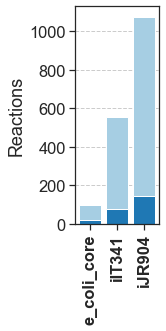

In [27]:
sns.set(font_scale=1.5, style='ticks')

f = plt.figure()

df = size_df.sort_values(by='reactions', ascending=True)
c1, c2 = sns.color_palette('Paired', 2)

plt.bar(x=df.model, height=df.reactions, color=c1)
plt.bar(x=df.model, height=df.boundary, color=c2)

ax = plt.gca()
plt.ylabel('Reactions')
plt.yticks(range(0, 1200, 200))
plt.setp(ax.get_xticklabels(), rotation=90, weight='bold')
ax.legend(['Total', 'Boundary'], framealpha=1).set_visible(False)

plt.grid(True, ls='--', axis='y')

f.set_size_inches(1.5, 4)
f.savefig(join(plot_dir, 'model_sizes_unicellular.svg'), bbox_inches='tight')

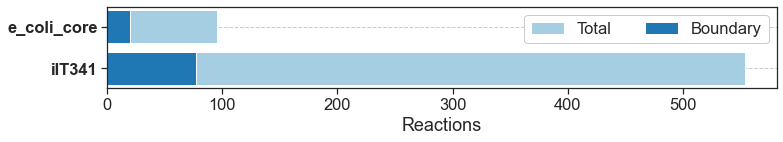

In [28]:
sns.set(font_scale=1.5, style='ticks')

f = plt.figure()

df = size_df
df = df[~df.model.str.startswith('iJR904')]
df = df.sort_values(by='reactions', ascending=False)

c1, c2 = sns.color_palette('Paired', 2)

plt.barh(y=df.model, width=df.reactions, color=c1)
plt.barh(y=df.model, width=df.boundary, color=c2)

ax = plt.gca()
plt.xlabel('Reactions')
plt.xticks(range(0, 600, 100))
plt.setp(ax.get_yticklabels(), rotation=0, weight='bold')
ax.legend(['Total', 'Boundary'], framealpha=1, ncol=2).set_visible(True)

plt.grid(True, ls='--', axis='y')

f.set_size_inches(12, 1.5)
f.savefig(join(plot_dir, 'model_sizes_unicellular.svg'), bbox_inches='tight')

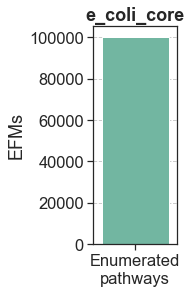

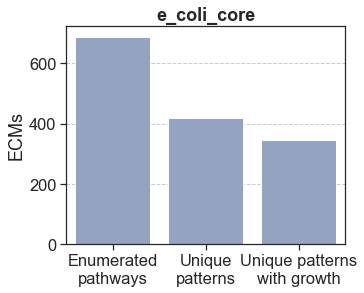

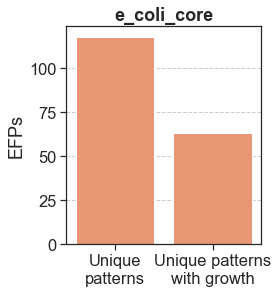

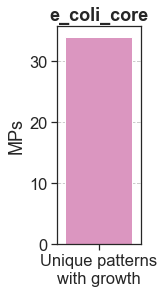

In [29]:
for x in pathway_order:

    sns.set(font_scale=1.5, style='ticks')

    f = plt.figure()

    df = cnt_df[cnt_df.pathway == x]
    if x == 'efm':
        df = df[df.matrix == 'full']
    elif x == 'efp':
        df = df[df.matrix != 'full']
    elif x == 'mp':
        df = df[df.matrix == 'growth']
    
    ax = sns.barplot(x=df.matrix, y=df.cnt, color=pathway_palette[x])
    
    plt.title(model_id.replace('_ecm', '').replace('_minII', ''), weight='bold')
    plt.ylabel('{}'.format(x.upper() + 's'))
    plt.xlabel('')
    if x == 'efm':
        ax.set_xticklabels([l.format(x.upper() + 's') for l in ['Enumerated\npathways']])
    elif x == 'efp':
        ax.set_xticklabels([l.format(x.upper() + 's') for l in ['Unique\npatterns', 'Unique patterns\nwith growth']])
    elif x == 'mp':
        ax.set_xticklabels([l.format(x.upper() + 's') for l in ['Unique patterns\nwith growth']])
    else:
        ax.set_xticklabels([l.format(x.upper() + 's') for l in ['Enumerated\npathways', 'Unique\npatterns', 'Unique patterns\nwith growth']])
    plt.grid(axis='y', ls='--')
    
    if x == 'mp' and model_id.startswith('i'):
        plt.ylim(0, 1400)
    
    if x in ('mp', 'efm'):
        f.set_size_inches(1.5, 4)
    elif x == 'efp':
        f.set_size_inches(3.5, 4)
    else:
        f.set_size_inches(5, 4)

    f.savefig(join(plot_dir, x + '_counts_' + model_id + '.svg'), bbox_inches='tight')

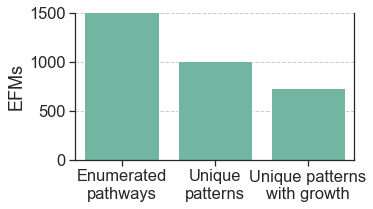

In [30]:
if 'efm' in pathway_order:

    sns.set(font_scale=1.5, style='ticks')

    f = plt.figure()

    df = cnt_df[cnt_df.pathway == 'efm']
    palette = [pathway_palette[x] for x in pathway_order]

    ax = sns.barplot(x=df.matrix, y=df.cnt, hue=df.pathway, palette=palette)

    plt.ylabel('EFMs')
    plt.xlabel('')
    plt.ylim(0, 1500)
    ax.set_xticklabels(['Enumerated\npathways', 'Unique\npatterns', 'Unique patterns\nwith growth'])
    plt.grid(axis='y', ls='--')

    h, l = ax.get_legend_handles_labels()
    ax.legend(h, [x.upper() + 's' for x in l], ncol=1, framealpha=1).set_visible(False)
    
    ax.spines['top'].set_visible(False)

    f.set_size_inches(5, 2.7)
    f.savefig(join(plot_dir, 'efm_counts_' + model_id + '_bottom.svg'), bbox_inches='tight')

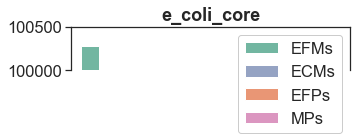

In [31]:
if model_id == 'e_coli_core':
    sns.set(font_scale=1.5, style='ticks')

    f = plt.figure()

    df = cnt_df
    palette = [pathway_palette[x] for x in pathway_order]

    ax = sns.barplot(x=df.matrix, y=df.cnt, hue=df.pathway, palette=palette)

    plt.title(model_id.replace('_ecm', '').replace('_minII', ''), weight='bold')
    plt.xlabel('')
    plt.ylabel('')
    plt.ylim(100000, 100500)
    ax.set_xticks([])
    plt.grid(axis='y', ls='--')

    h, l = ax.get_legend_handles_labels()
    ax.legend(h, [x.upper() + 's' for x in l], ncol=1, framealpha=1).set_visible(True)

    ax.spines['bottom'].set_visible(False)
    
    # ax.set_xticklabels(ax.get_xticklabels(), fontsize=14)
    f.set_size_inches(5, 0.8)
    f.savefig(join(plot_dir, 'pathway_counts_' + model_id + '_top.svg'), bbox_inches='tight')

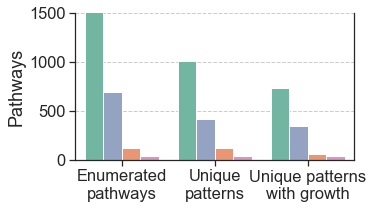

In [32]:
if model_id == 'e_coli_core':
    sns.set(font_scale=1.5, style='ticks')

    f = plt.figure()

    df = cnt_df
    palette = [pathway_palette[x] for x in pathway_order]

    ax = sns.barplot(x=df.matrix, y=df.cnt, hue=df.pathway, palette=palette)

    plt.ylabel('Pathways')
    plt.xlabel('')
    plt.ylim(0, 1500)
    ax.set_xticklabels(['Enumerated\npathways', 'Unique\npatterns', 'Unique patterns\nwith growth'])
    plt.grid(axis='y', ls='--')

    h, l = ax.get_legend_handles_labels()
    ax.legend(h, [x.upper() + 's' for x in l], ncol=1, framealpha=1).set_visible(False)

    ax.spines['top'].set_visible(False)
    
    f.set_size_inches(5, 2.7)
    f.savefig(join(plot_dir, 'pathway_counts_' + model_id + '_bottom.svg'), bbox_inches='tight')

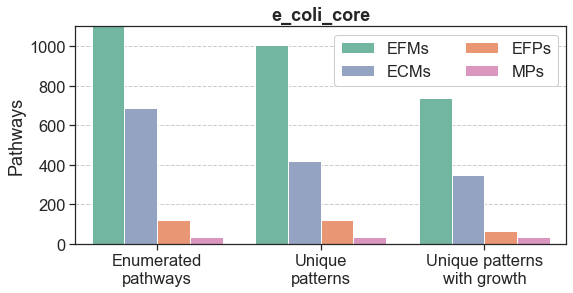

In [33]:
if model_id.startswith('e_coli_core'):
    sns.set(font_scale=1.5, style='ticks')

    f = plt.figure()
    
    df = cnt_df
    palette = [pathway_palette[x] for x in pathway_order]

    ax = sns.barplot(x=df.matrix, y=df.cnt, hue=df.pathway, palette=palette)

    plt.title(model_id.replace('_ecm', '').replace('_minII', ''), weight='bold')
    plt.ylabel('Pathways')
    plt.xlabel('')
    plt.ylim(0, 1100)
    ax.set_xticklabels(['Enumerated\npathways', 'Unique\npatterns', 'Unique patterns\nwith growth'])
    plt.grid(axis='y', ls='--')

    h, l = ax.get_legend_handles_labels()
    ax.legend(h, [x.upper() + 's' for x in l], ncol=2, framealpha=1)

    f.set_size_inches(8.8, 4)
    f.savefig(join(plot_dir, 'pathway_counts_' + model_id + '.svg'), bbox_inches='tight')

In [34]:
if model_id.startswith('iIT341'):
    sns.set(font_scale=1.5, style='ticks')

    f = plt.figure()

    df = cnt_df
    df = df[df.pathway.isin(['efp', 'mp'])]
    df = df[df.matrix != 'full']
    palette = [pathway_palette[x] for x in pathway_order if x in ['efp', 'mp']]

    ax = sns.barplot(x=df.matrix, y=df.cnt, hue=df.pathway, palette=palette)

    plt.title(model_id.replace('_ecm', '').replace('_minII', ''), weight='bold')
    plt.ylabel('Pathways')
    plt.xlabel('')
    ax.set_xticklabels(['Unique\npatterns', 'Unique patterns\nwith growth'])
    plt.grid(axis='y', ls='--')

    h, l = ax.get_legend_handles_labels()
    ax.legend(h, [x.upper() + 's' for x in l], ncol=1, framealpha=1)

    f.set_size_inches(3.5, 4)
    f.savefig(join(plot_dir, 'pathway_counts_' + model_id + '.svg'), bbox_inches='tight')

findfont: Font family ['cursive'] not found. Falling back to DejaVu Sans.


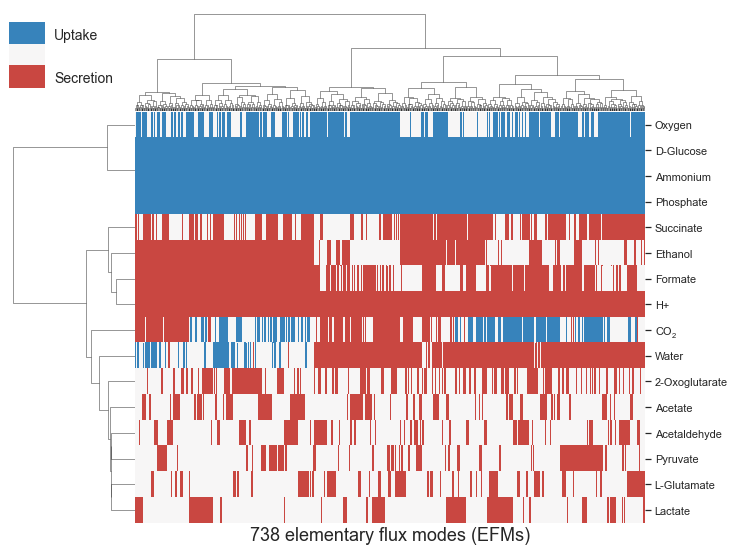

In [35]:
if 'efm' in pathway_order:
    # Cluster EFPs
    sns.set(style='ticks', font_scale=1)

    df = efm_dfs['growth'].T
    
    figsize = (10, 7.5) if model_id == 'e_coli_core' else (10, 10)

    g = sns.clustermap(df, method='ward', cmap=cmap, xticklabels=False, yticklabels=1, figsize=figsize)

    g.ax_cbar.set_ylim([1.5, -1.5])
    g.ax_cbar.yaxis.set_ticks([-2/3, 0, 2/3])
    g.ax_cbar.tick_params(right=False)
    g.ax_cbar.set_yticklabels(['Uptake', '', 'Secretion'], fontsize=14)
    g.ax_heatmap.set_xlabel('{} elementary flux modes (EFMs)'.format(df.shape[1]), fontsize=18)
    g.ax_heatmap.set_yticklabels([met_names[x.get_text()].split(' ')[0] for x in g.ax_heatmap.get_yticklabels()])
#     .replace('2', '$_{2}$')
    
    g.savefig(join(plot_dir, 'efm_clustermap_' + model_id + '.png'), bbox_inches='tight', dpi=300)

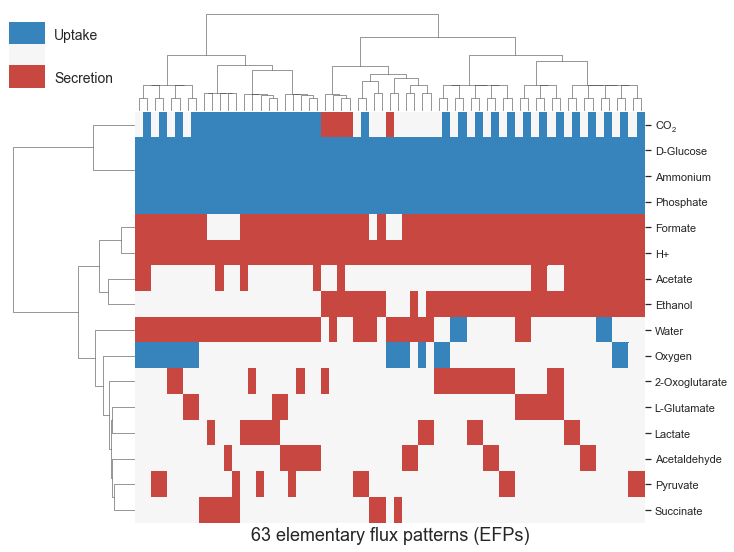

In [36]:
if 'efp' in pathway_order:
    # Cluster EFPs
    sns.set(style='ticks', font_scale=1)

    df = efp_dfs['growth'].T
    
    figsize = (10, 7.5) if model_id == 'e_coli_core' else (10, 10)

    g = sns.clustermap(df, method='ward', cmap=cmap, xticklabels=False, yticklabels=1, figsize=figsize)

    g.ax_cbar.set_ylim([1.5, -1.5])
    g.ax_cbar.yaxis.set_ticks([-2/3, 0, 2/3])
    g.ax_cbar.tick_params(right=False)
    g.ax_cbar.set_yticklabels(['Uptake', '', 'Secretion'], fontsize=14)
    g.ax_heatmap.set_xlabel('{} elementary flux patterns (EFPs)'.format(df.shape[1]), fontsize=18)
    g.ax_heatmap.set_yticklabels([met_names[x.get_text()].split(' ')[0] for x in g.ax_heatmap.get_yticklabels()])
#     .replace('2', '$_{2}$')
    
    g.savefig(join(plot_dir, 'efp_clustermap_' + model_id + '.png'), bbox_inches='tight', dpi=300)

All ECMs


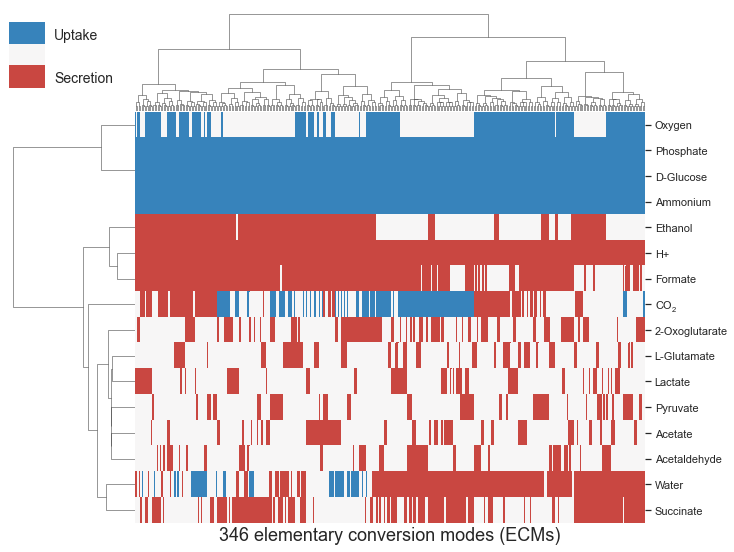

In [37]:
if 'ecm' in pathway_order:
    # Cluster ECMs
    sns.set(style='ticks', font_scale=1)

    # Sample if there are more than 10,000 ECMs
#     sample = len(ecms) > 1e4
    sample = False
    if sample:
#         n = len(mps)
        n = int(1e4)
        df = ecm_dfs['growth'].sample(n).T
    else:
        df = ecm_dfs['growth'].T
    print(['All ECMs', 'Sampled ECMs'][sample])
    
    figsize = (10, 7.5) if model_id == 'e_coli_core' else (10, 10)

    g = sns.clustermap(df, method='ward', cmap=cmap, xticklabels=False, yticklabels=1, figsize=figsize)

    g.ax_cbar.set_ylim([1.5, -1.5])
    g.ax_cbar.yaxis.set_ticks([-2/3, 0, 2/3])
    g.ax_cbar.tick_params(right=False)
    g.ax_cbar.set_yticklabels(['Uptake', '', 'Secretion'], fontsize=14)
    g.ax_heatmap.set_xlabel('{} elementary conversion modes (ECMs)'.format(df.shape[1]), fontsize=18)
    g.ax_heatmap.set_yticklabels([met_names[x.get_text()].split(' ')[0] for x in g.ax_heatmap.get_yticklabels()])

    g.savefig(join(plot_dir, 'ecm_clustermap_' + model_id + '.png'), bbox_inches='tight', dpi=300)

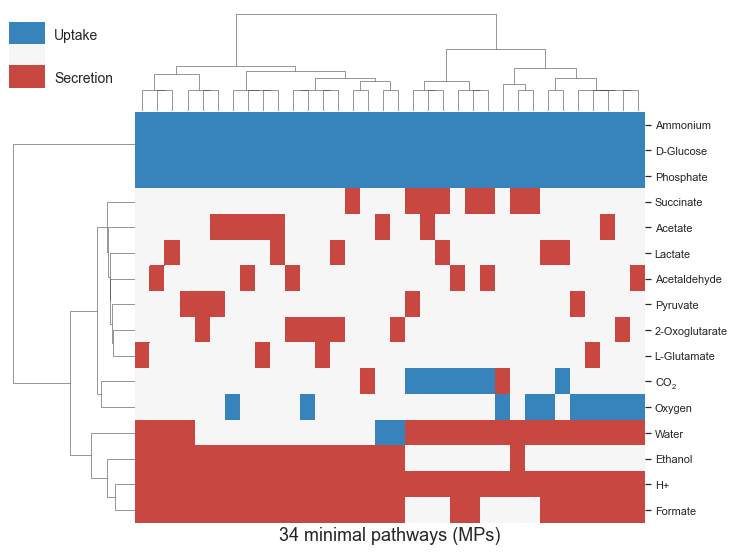

In [38]:
if 'mp' in pathway_order:
    # Cluster MPs
    sns.set(style='ticks', font_scale=1)

    df = mp_df.T
    
    figsize = (10, 7.5) if model_id == 'e_coli_core' else (10, 10)

    g = sns.clustermap(df, method='ward', cmap=cmap, xticklabels=False, yticklabels=1, figsize=figsize)

    g.ax_cbar.set_ylim([1.5, -1.5])
    g.ax_cbar.yaxis.set_ticks([-2/3, 0, 2/3])
    g.ax_cbar.tick_params(right=False)
    g.ax_cbar.set_yticklabels(['Uptake', '', 'Secretion'], fontsize=14)
    g.ax_heatmap.set_xlabel('{} minimal pathways (MPs)'.format(df.shape[1]), fontsize=18)
    g.ax_heatmap.set_yticklabels([met_names[x.get_text()].split(' ')[0] for x in g.ax_heatmap.get_yticklabels()])

    g.savefig(join(plot_dir, 'mp_clustermap_' + model_id + '.png'), bbox_inches='tight', dpi=300)

c:\Users\ylwe\.conda\envs\unbiased_analysis\lib\site-packages\seaborn\distributions.py:565: MatplotlibDeprecationWarning: Saw kwargs ['ec', 'edgecolor'] which are all aliases for 'edgecolor'.  Kept value from 'edgecolor'.  Passing multiple aliases for the same property will raise a TypeError in 3.3.
  artists = plot_func(
c:\Users\ylwe\.conda\envs\unbiased_analysis\lib\site-packages\seaborn\distributions.py:565: MatplotlibDeprecationWarning: Saw kwargs ['ec', 'edgecolor'] which are all aliases for 'edgecolor'.  Kept value from 'edgecolor'.  Passing multiple aliases for the same property will raise a TypeError in 3.3.
  artists = plot_func(
c:\Users\ylwe\.conda\envs\unbiased_analysis\lib\site-packages\seaborn\distributions.py:565: MatplotlibDeprecationWarning: Saw kwargs ['ec', 'edgecolor'] which are all aliases for 'edgecolor'.  Kept value from 'edgecolor'.  Passing multiple aliases for the same property will raise a TypeError in 3.3.
  artists = plot_func(
c:\Users\ylwe\.conda\envs\un

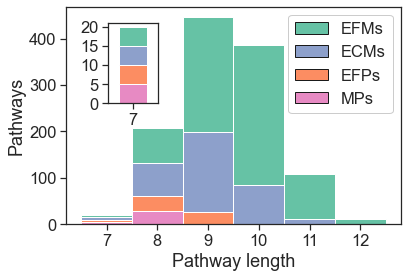

In [39]:
sns.set(style='ticks', font_scale=1.5)

f = plt.figure()

df = stat_df

x = df.length
xmin, xmax = np.min(x), np.max(x)
bins = xmax - xmin + 1
binrange = xmin - 0.5, xmax + 0.5

ax = sns.histplot(x=x, hue=df.pathway, stat='count', common_norm=True, bins=bins, binrange=binrange, multiple='stack', palette=pathway_palette, ec='k', alpha=1)

plt.xticks(range(xmin, xmax + 1))
plt.xlabel('Pathway length')
plt.ylabel('Pathways')

# Workaround for histplot legend bug
l = ax.get_legend()
h = l.legendHandles
l.remove()
ax.legend(h, [x.upper() + 's' for x in pathway_order], framealpha=1).set_visible(True)

# Inset
if model_id == 'e_coli_core':
    axi = inset_axes(ax, width=0.7, height=1.12, bbox_to_anchor=(0.3, 0.965, 0, 0), bbox_transform=ax.transAxes)
else:
    axi = inset_axes(ax, width=0.7, height=1.12, bbox_to_anchor=(0.31, 0.64, 0, 0), bbox_transform=ax.transAxes)

min_l = df.length.min()
df = stat_df
df = df[df.length == min_l]

if model_id == 'e_coli_core':
    binrange = (min_l - 0.2, min_l + 0.2)
elif model_id.startswith('iIT341'):
    binrange = (min_l - 0.5, min_l + 0.5)

sns.histplot(ax=axi, x=df.length, hue=df.pathway, stat='count', binrange=binrange, common_norm=True, multiple='stack', palette=pathway_palette, ec='k', alpha=1)

axi.legend().set_visible(False)
axi.set_xlim([min_l, min_l])
axi.set_xlabel('')
axi.set_ylabel('')
axi.set_xticks([min_l])

if model_id == 'e_coli_core':
    axi.set_yticks(range(0, 25, 5))
else:
    axi.set_yticks(range(0, 500, 100))

f.set_size_inches(6, 4)
f.savefig(join(plot_dir, 'pathways_length_' + model_id + '.svg'), bbox_inches='tight')

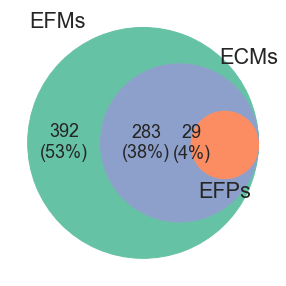

In [40]:
if model_id == 'e_coli_core':
    f = plt.figure()

    palette = [pathway_palette[x] for x in ['efm', 'ecm', 'efp']]

    v = venn3([set(efms), set(ecms), set(efps)], set_labels=['EFMs', 'ECMs', 'EFPs'], set_colors=palette, alpha=1)

    v.get_patch_by_id('100').set_color(palette[0])
    v.get_patch_by_id('110').set_color(palette[1])
    v.get_patch_by_id('111').set_color(palette[2])

    v.get_label_by_id('100').set_text('{}\n({:.0f}%)'.format(len(efms) - len(ecms), 100 * (len(efms) - len(ecms)) / len(efms)))
    v.get_label_by_id('110').set_text('{}\n({:.0f}%)'.format(len(ecms) - len(efps), 100 * (len(ecms) - len(efps)) / len(efms)))
    v.get_label_by_id('111').set_text('{}\n({:.0f}%)'.format(len(efps) - len(mps), 100 * (len(efps) - len(mps)) / len(efms)))

    f.set_size_inches(5, 5)
    f.savefig(join(plot_dir, 'pathways_venn_' + model_id + '_1.svg'), bbox_inches='tight', dpi=300)

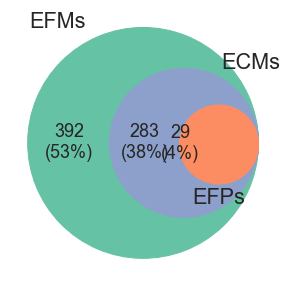

In [41]:
if model_id == 'e_coli_core':
    f = plt.figure()

    palette = [pathway_palette[x] for x in ['efm', 'ecm', 'efp']]
    
    all_efms = get_sets(pathway_dfs['efm']['unique'])
    all_efps = get_sets(pathway_dfs['efp']['unique'])
    
    all_ecms = set()
    for ecm in get_sets(pathway_dfs['ecm']['unique']):
        ecm = set(ecm)
        if 'objective' in ecm:
            ecm.remove('objective')
            ecm.add(objective)
        all_ecms.add(frozenset(ecm))
    
    v = venn3([set(all_efms), set(all_ecms), set(all_efps)], set_labels=['EFMs', 'ECMs', 'EFPs'], set_colors=palette, alpha=1)

    v.get_patch_by_id('100').set_color(palette[0])
    v.get_patch_by_id('110').set_color(palette[1])
    v.get_patch_by_id('111').set_color(palette[2])

    v.get_label_by_id('100').set_text('{}\n({:.0f}%)'.format(len(efms) - len(ecms), 100 * (len(efms) - len(ecms)) / len(efms)))
    v.get_label_by_id('110').set_text('{}\n({:.0f}%)'.format(len(ecms) - len(efps), 100 * (len(ecms) - len(efps)) / len(efms)))
    v.get_label_by_id('111').set_text('{}\n({:.0f}%)'.format(len(efps) - len(mps), 100 * (len(efps) - len(mps)) / len(efms)))

    f.set_size_inches(5, 5)
    f.savefig(join(plot_dir, 'pathways_venn_all_' + model_id + '_1.svg'), bbox_inches='tight', dpi=300)

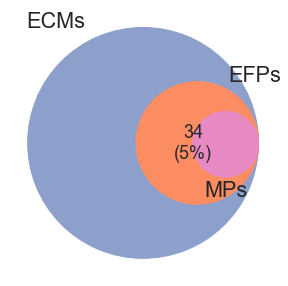

In [42]:
if model_id == 'e_coli_core':
    f = plt.figure()

    palette = [pathway_palette[x] for x in ['ecm', 'efp', 'mp']]
    
    all_efps = get_sets(pathway_dfs['efp']['unique'])
    
    all_ecms = set()
    for ecm in get_sets(pathway_dfs['ecm']['unique']):
        ecm = set(ecm)
        if 'objective' in ecm:
            ecm.remove('objective')
            ecm.add(objective)
        all_ecms.add(frozenset(ecm))
        
    all_mps = set()
    for mp in get_sets(pathway_dfs['mp']['unique']):
        mp = set(mp)
        mp.add(objective)
        all_mps.add(frozenset(mp))

    v = venn3([set(all_ecms), set(all_efps), set(all_mps)], set_labels=['ECMs', 'EFPs', 'MPs'], set_colors=palette, alpha=1)

    v.get_patch_by_id('100').set_color(palette[0])
    v.get_patch_by_id('110').set_color(palette[1])
    v.get_patch_by_id('111').set_color(palette[2])

    v.get_label_by_id('100').set_text('')
    v.get_label_by_id('110').set_text('')
    v.get_label_by_id('111').set_text('{}\n({:.0f}%)'.format(len(mps), 100 * len(mps) / len(efms)))

    f.set_size_inches(5, 5)
    f.savefig(join(plot_dir, 'pathways_venn_' + model_id + '_2.svg'), bbox_inches='tight', dpi=300)

In [43]:
if model_id.startswith('iIT341'):
    f = plt.figure()

    palette = [pathway_palette[x] for x in ['ecm', 'efp', 'mp']]

    v = venn3([set(ecms), set(efps), set(mps)], set_labels=['ECMs', 'EFPs', 'MPs'], set_colors=palette, alpha=1)

    v.get_patch_by_id('100').set_color(palette[0])
    v.get_patch_by_id('110').set_color(palette[1])
    v.get_patch_by_id('111').set_color(palette[2])

    v.get_label_by_id('100').set_text('{}\n({:.0f}%)'.format(len(ecms) - len(efps), 100 * (len(ecms) - len(efps)) / len(ecms)))
    v.get_label_by_id('110').set_text('{}\n({:.0f}%)'.format(len(efps) - len(mps), 100 * (len(efps) - len(mps)) / len(ecms)))
    v.get_label_by_id('111').set_text('{}\n({:.0f}%)'.format(len(mps), 100 * len(mps) / len(ecms)))

    f.set_size_inches(5, 5)
    f.savefig(join(plot_dir, 'pathways_venn_' + model_id + '.svg'), bbox_inches='tight', dpi=300)

c:\Users\ylwe\.conda\envs\unbiased_analysis\lib\site-packages\seaborn\distributions.py:565: MatplotlibDeprecationWarning: Saw kwargs ['ec', 'edgecolor'] which are all aliases for 'edgecolor'.  Kept value from 'edgecolor'.  Passing multiple aliases for the same property will raise a TypeError in 3.3.
  artists = plot_func(
c:\Users\ylwe\.conda\envs\unbiased_analysis\lib\site-packages\seaborn\distributions.py:565: MatplotlibDeprecationWarning: Saw kwargs ['ec', 'edgecolor'] which are all aliases for 'edgecolor'.  Kept value from 'edgecolor'.  Passing multiple aliases for the same property will raise a TypeError in 3.3.
  artists = plot_func(
c:\Users\ylwe\.conda\envs\unbiased_analysis\lib\site-packages\seaborn\distributions.py:565: MatplotlibDeprecationWarning: Saw kwargs ['ec', 'edgecolor'] which are all aliases for 'edgecolor'.  Kept value from 'edgecolor'.  Passing multiple aliases for the same property will raise a TypeError in 3.3.
  artists = plot_func(


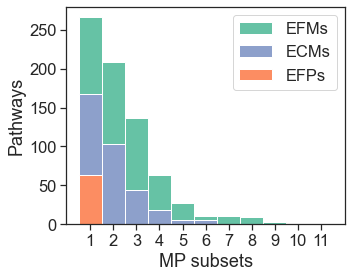

In [44]:
if model_id == 'e_coli_core':

    sns.set(style='ticks', font_scale=1.5)

    f = plt.figure()

    df = stat_df
    df = df[df.pathway != 'mp']

    x = df.mp_subsets.astype(int)
    xmin, xmax = np.min(x), np.max(x)
    bins = xmax - xmin + 1
    binrange = xmin - 0.5, xmax + 0.5

    hue_order = ['efp', 'ecm', 'efm']
    palette = [pathway_palette[x] for x in hue_order]

    ax = sns.histplot(x=x, hue=df.pathway, hue_order=hue_order, bins=bins, binrange=binrange, palette=palette, ec='k', multiple='layer', alpha=1)

    plt.xticks(range(xmin, xmax + 1))
    plt.xlabel('MP subsets')
    plt.ylabel('Pathways')

    ax.legend(['EFMs', 'ECMs', 'EFPs'])

    f.set_size_inches(5, 4)
    f.savefig(join(plot_dir, 'mp_subsets_' + model_id + '.svg'), bbox_inches='tight')

In [45]:
if model_id.startswith('iIT341'):
    
    sns.set(style='ticks', font_scale=1.5)

    f = plt.figure()

    df = stat_df
    df = df[df.pathway != 'mp']

    x = df.mp_subsets.astype(int)
    xmin, xmax = np.min(x), np.max(x)
    bins = xmax - xmin + 1
    binrange = xmin - 0.5, xmax + 0.5
    
    hue_order = ['efp', 'ecm']
    palette = [pathway_palette[x] for x in hue_order]

    ax = sns.histplot(x=x, hue=df.pathway, hue_order=hue_order, palette=palette, bins=bins, binrange=binrange, ec='k', alpha=1)

    plt.xticks(range(xmin, xmax + 1))
    plt.xlabel('MP subsets')
    plt.ylabel('ECMs')

    ax.legend(['ECMs', 'EFPs'])

    f.set_size_inches(5, 4)
    f.savefig(join(plot_dir, 'mp_subsets_' + model_id + '.svg'), bbox_inches='tight')

c:\Users\ylwe\.conda\envs\unbiased_analysis\lib\site-packages\seaborn\distributions.py:565: MatplotlibDeprecationWarning: Saw kwargs ['ec', 'edgecolor'] which are all aliases for 'edgecolor'.  Kept value from 'edgecolor'.  Passing multiple aliases for the same property will raise a TypeError in 3.3.
  artists = plot_func(
c:\Users\ylwe\.conda\envs\unbiased_analysis\lib\site-packages\seaborn\distributions.py:565: MatplotlibDeprecationWarning: Saw kwargs ['ec', 'edgecolor'] which are all aliases for 'edgecolor'.  Kept value from 'edgecolor'.  Passing multiple aliases for the same property will raise a TypeError in 3.3.
  artists = plot_func(
c:\Users\ylwe\.conda\envs\unbiased_analysis\lib\site-packages\seaborn\distributions.py:565: MatplotlibDeprecationWarning: Saw kwargs ['ec', 'edgecolor'] which are all aliases for 'edgecolor'.  Kept value from 'edgecolor'.  Passing multiple aliases for the same property will raise a TypeError in 3.3.
  artists = plot_func(
c:\Users\ylwe\.conda\envs\un

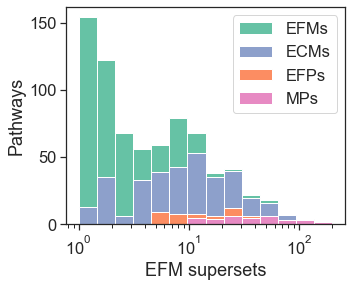

In [46]:
if model_id == 'e_coli_core':
    
    sns.set(style='ticks', font_scale=1.5)

    f = plt.figure()

    df = stat_df
    
    x = df.efm_supersets.astype(int)
    xmin, xmax = np.min(x), np.max(x)
    bins = xmax - xmin + 1
    binrange = xmin - 0.5, xmax + 0.5

    bins = 14
    xt = [1e0, 1e1, 1e2]

    hue_order = ['mp', 'efp', 'ecm', 'efm']
    palette = [pathway_palette[x] for x in hue_order]

    ax = sns.histplot(x=x, hue=df.pathway, hue_order=hue_order, bins=bins, log_scale=True, palette=palette, ec='k', multiple='layer', alpha=1)

    plt.xlabel('EFM supersets')
    plt.ylabel('Pathways')

    ax.legend(['EFMs', 'ECMs', 'EFPs', 'MPs'])
    ax.set_xticks(xt)

    f.set_size_inches(5, 4)
    f.savefig(join(plot_dir, 'efm_supersets_' + model_id + '.svg'), bbox_inches='tight')

In [47]:
if model_id.startswith('iIT341'):
    sns.set(style='ticks', font_scale=1.5)

    f = plt.figure()

    df = stat_df
#     df = df[df.pathway != 'efp']

    x = df.ecm_supersets.astype(int)
    xmin, xmax = np.min(x), np.max(x)

    hue_order = ['ecm', 'efp', 'mp']
    palette = [pathway_palette[x] for x in hue_order]
    
    bins = 22
    xt = [1e0, 1e1, 1e2, 1e3]
    
    ax = sns.histplot(x=x, hue=df.pathway, hue_order=hue_order, log_scale=True, bins=bins, palette=palette, ec='k', multiple='layer', alpha=1)

    # plt.xlim(xmin - 10, xmax + 100)
    plt.xlabel('ECM supersets')
    plt.ylabel('Pathways')
    
    h = ax.get_legend().legendHandles
    ax.legend(h, ['ECMs', 'EFPs', 'MPs'], ncol=2)
    ax.set_xticks(xt)
    
    # Inset
    axi = inset_axes(ax, width=2.2, height=1.3, bbox_to_anchor=(1, 0.74, 0, 0), bbox_transform=ax.transAxes)

    df = stat_df
#     df = df[df.pathway == 'mp']

    x = df[df.pathway != 'ecm'].ecm_supersets.astype(int)
    xmin, xmax = np.min(x), np.max(x)
    
    hue_order = ['mp', 'efp']
    palette = [pathway_palette[x] for x in hue_order]

    sns.histplot(ax=axi, x=x, hue=df.pathway, hue_order=hue_order, log_scale=True, bins=bins, palette=palette, ec='k', multiple='layer', alpha=1)

    axi.legend().set_visible(False)
    axi.set_xlabel('')
    axi.set_ylabel('')
    axi.set_xticks(xt)
    axi.set_yticks(np.arange(0, 800, 200))

    f.set_size_inches(5, 4)
    f.savefig(join(plot_dir, 'ecm_supersets_' + model_id + '.svg'), bbox_inches='tight')

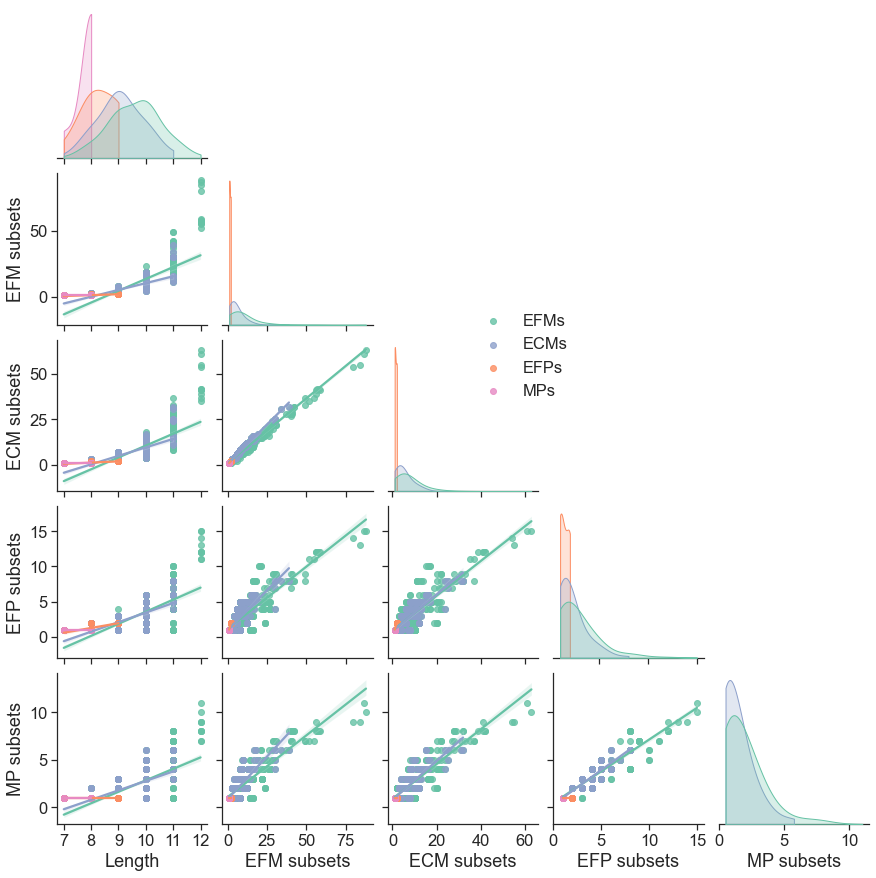

In [48]:
if model_id == 'e_coli_core':
    sns.set(font_scale=1.5, style='ticks')

    vars = ['length', 'efm_subsets', 'ecm_subsets', 'efp_subsets', 'mp_subsets']

    df = stat_df[vars + ['pathway']].copy()
    df.pathway = df.pathway.str.upper() + 's'
    df.columns = [x.replace('efm_', 'EFM ').replace('efp_', 'EFP ').replace('ecm_', 'ECM ').replace('mp_', 'MP ').replace('len', 'Len') for x in df.columns]

    palette = [pathway_palette[x] for x in pathway_order]

    g = sns.pairplot(df, hue='pathway', kind='reg', corner=True, diag_kws=dict(common_norm=False, bw_adjust=2, cut=0), palette=palette)

    x = df.Length.astype(int)
    xmin, xmax = np.min(x), np.max(x)
    ax = g.axes[3][0]
    ax.set_xticks(range(xmin, xmax + 1))
    
    g.axes[3][0].set_yticks([0, 5, 10, 15])
    g.axes[4][0].set_yticks([0, 5, 10])
    g.axes[4][1].set_xticks([0, 25, 50, 75])
    g.axes[4][2].set_xticks([0, 20, 40, 60])
    g.axes[4][3].set_xticks([0, 5, 10, 15])
    g.axes[4][4].set_xticks([0, 5, 10])
    
    g._legend.set_bbox_to_anchor((0.58, 0.58))
    g._legend.set_title('')

    g.savefig(join(plot_dir, 'pathway_subsets_' + model_id + '.png'), bbox_inches='tight', dpi=300)

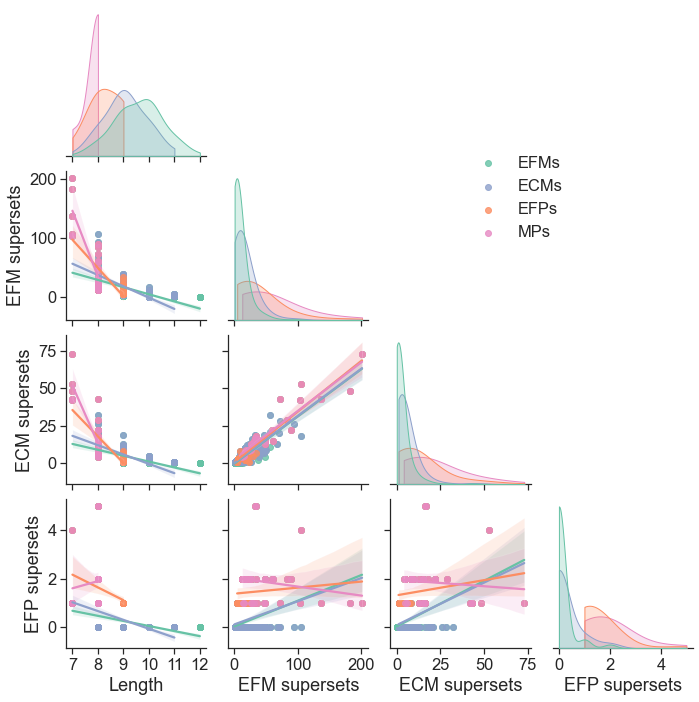

In [49]:
if model_id == 'e_coli_core':
    sns.set(font_scale=1.5, style='ticks')

    vars = ['length', 'efm_supersets', 'ecm_supersets', 'efp_supersets']

    df = stat_df[vars + ['pathway']].copy()
    df.pathway = df.pathway.str.upper() + 's'
    df.columns = [x.replace('efm_', 'EFM ').replace('efp_', 'EFP ').replace('ecm_', 'ECM ').replace('mp_', 'MP ').replace('len', 'Len') for x in df.columns]

    palette = [pathway_palette[x] for x in pathway_order]

    g = sns.pairplot(df, hue='pathway', kind='reg', corner=True, diag_kws=dict(common_norm=False, bw_adjust=2, cut=0), palette=palette)

    x = df.Length.astype(int)
    xmin, xmax = np.min(x), np.max(x)
    ax = g.axes[2][0]
    ax.set_xticks(range(xmin, xmax + 1))
    
    g.axes[3][1].set_xticks([0, 100, 200])
    g.axes[3][2].set_xticks([0, 25, 50, 75])
    g.axes[3][3].set_xticks([0, 2, 4])
    
    g._legend.set_bbox_to_anchor((0.7, 0.7))
    g._legend.set_title('')

    g.savefig(join(plot_dir, 'pathway_supersets_' + model_id + '.png'), bbox_inches='tight', dpi=300)

In [50]:
if model_id.startswith('iIT341'):
    sns.set(font_scale=1.5, style='ticks')

    df = stat_df
    
    vars = ['length', 'ecm_subsets', 'efp_subsets', 'mp_subsets']

#     df = df[df.pathway != 'mp']
    df = df[vars + ['pathway']].copy()
#     df = df.sample(50000)
    df.pathway = df.pathway.str.upper() + 's'
    df.columns = [x.replace('efp_', 'EFP ').replace('ecm_', 'ECM ').replace('mp_', 'MP ').replace('len', 'Len') for x in df.columns]
    
    palette = [pathway_palette[x] for x in pathway_order if x != 'efm']

    g = sns.pairplot(df, hue='pathway', kind='scatter', plot_kws=dict(alpha=1), corner=True, diag_kws=dict(common_norm=False, bw_adjust=6, cut=0), palette=palette)

    x = df.Length.astype(int)
    xmin, xmax = np.min(x), np.max(x)
    ax = g.axes[2][0]
    ax.set_xticks(range(xmin, xmax + 1, 2))
    ax.set_xlim(xmin - 1, xmax + 1)
    
    g.axes[2][0].set_yticks([0, 10, 20])
    g.axes[2][2].set_xticks([0, 10, 20])
    g.axes[3][0].set_yticks([0, 5, 10])
    g.axes[3][3].set_xticks([0, 5, 10])
    g.axes[1][0].set_yticks([0, 50, 100])
    g.axes[3][1].set_xticks([0, 50, 100])
    
    g._legend.set_bbox_to_anchor((0.7, 0.58))
    g._legend.set_title('')

    g.savefig(join(plot_dir, 'pathway_subsets_' + model_id + '.png'), bbox_inches='tight', dpi=300)

In [51]:
if model_id.startswith('iIT341'):
    sns.set(font_scale=1.5, style='ticks')

    vars = ['length', 'ecm_supersets', 'efp_supersets']

    df = stat_df[vars + ['pathway']].copy()
    df.pathway = df.pathway.str.upper() + 's'
    df.columns = [x.replace('efp_', 'EFP ').replace('ecm_', 'ECM ').replace('mp_', 'MP ').replace('len', 'Len') for x in df.columns]

    palette = [pathway_palette[x] for x in pathway_order if x != 'efm']

    g = sns.pairplot(df, hue='pathway', corner=True, diag_kws=dict(common_norm=False, bw_adjust=6, cut=0), palette=palette)

    x = df.Length.astype(int)
    xmin, xmax = np.min(x), np.max(x)
    ax = g.axes[1][0]
    ax.set_xticks(range(xmin, xmax + 1, 2))
    ax.set_xlim(xmin - 1, xmax + 1)
    
    g.axes[1][1].set_xticks([0, 2000, 4000])
    g.axes[2][2].set_xticks([0, 10, 20])
    
    g._legend.set_bbox_to_anchor((0.7, 0.7))
    g._legend.set_title('')

    g.savefig(join(plot_dir, 'pathway_supersets_' + model_id + '.png'), bbox_inches='tight', dpi=300)

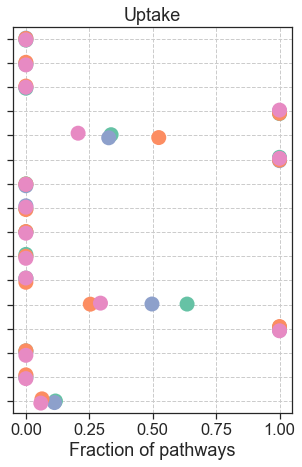

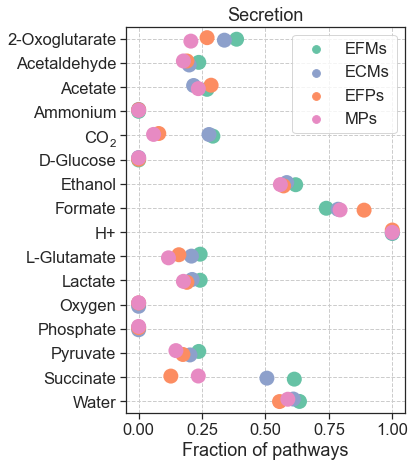

In [52]:
for x in set(frac_df.direction):
    f = plt.figure()

    df = frac_df
    df = df[df.direction == x]

    ax = sns.stripplot(y='metabolite', x='fraction', hue='pathway', data=df, palette=pathway_palette, s=15)

    plt.title(x.capitalize())
    plt.grid(True, ls='--')
    plt.xlabel('Fraction of pathways')
    plt.ylabel('')
    
    if model_id == 'e_coli_core':
        h, l = ax.get_legend_handles_labels()
        ax.legend(h, ['EFMs', 'ECMs', 'EFPs', 'MPs'], ncol=1)
    elif model_id.startswith('iIT341'):
        h, l = ax.get_legend_handles_labels()
        ax.legend(h, ['ECMs', 'EFPs', 'MPs'])
    elif model_id.startswith('iJR904'):
        h, l = ax.get_legend_handles_labels()
        ax.legend(h, ['MPs'])
        
    if x == 'uptake':
        ax.set_yticklabels([])
        ax.legend().set_visible(False)
    
    if model_id.startswith('iIT341'):
        f.set_size_inches(5, len(df) / 9)
    else:
        f.set_size_inches(5, len(df) / 9)

    f.savefig(join(plot_dir, x + '_frequencies_' + model_id + '.svg'), bbox_inches='tight')

efm
ecm
efp
mp


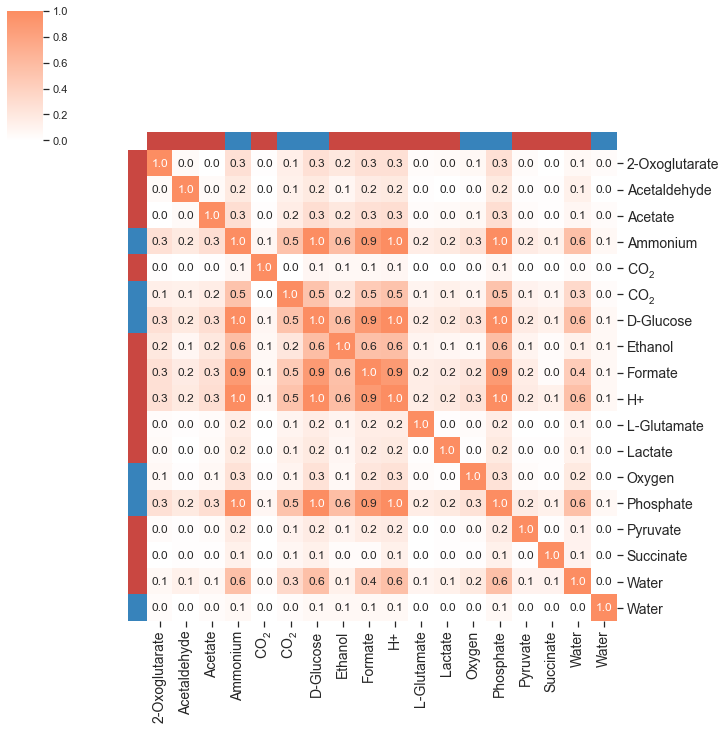

In [53]:
font_scale = 1 if model_id == 'e_coli_core' else 0.1
font_scale = 1
sns.set(style='ticks', font_scale=font_scale)

for pathway in pathway_order:
    print(pathway)
    if not pathway == 'efp':
        continue
        
    df = frac_pair_dfs[pathway]
        
    l = [met_names[x] for x in df.index]
    c = [[cmap[-1], cmap[0]][x.endswith('_rev')] for x in df.index]
    cm = LinearSegmentedColormap.from_list(pathway, [(1, 1, 1), pathway_palette[pathway]])
    annot = model_id == 'e_coli_core'
    
    g = sns.clustermap(df, cmap=cm, xticklabels=l, yticklabels=l, row_cluster=False, col_cluster=False, col_colors=c, row_colors=c, annot=annot, fmt='.1f')
    
#     g.ax_cbar.set_visible(False)
    g.ax_row_dendrogram.set_visible(False)
    g.ax_col_dendrogram.set_visible(False)
    g.ax_heatmap.set_xticklabels(g.ax_heatmap.get_xticklabels(), fontsize=14)
    g.ax_heatmap.set_yticklabels(g.ax_heatmap.get_yticklabels(), fontsize=14)
    
    g.savefig(join(plot_dir, model_id + '_' + pathway + '_frequencies_pair_heatmap.svg'), bbox_inches='tight', dpi=300)

c:\Users\ylwe\.conda\envs\unbiased_analysis\lib\site-packages\seaborn\distributions.py:565: MatplotlibDeprecationWarning: Saw kwargs ['ec', 'edgecolor'] which are all aliases for 'edgecolor'.  Kept value from 'edgecolor'.  Passing multiple aliases for the same property will raise a TypeError in 3.3.
  artists = plot_func(
c:\Users\ylwe\.conda\envs\unbiased_analysis\lib\site-packages\seaborn\distributions.py:565: MatplotlibDeprecationWarning: Saw kwargs ['ec', 'edgecolor'] which are all aliases for 'edgecolor'.  Kept value from 'edgecolor'.  Passing multiple aliases for the same property will raise a TypeError in 3.3.
  artists = plot_func(
c:\Users\ylwe\.conda\envs\unbiased_analysis\lib\site-packages\seaborn\distributions.py:565: MatplotlibDeprecationWarning: Saw kwargs ['ec', 'edgecolor'] which are all aliases for 'edgecolor'.  Kept value from 'edgecolor'.  Passing multiple aliases for the same property will raise a TypeError in 3.3.
  artists = plot_func(
c:\Users\ylwe\.conda\envs\un

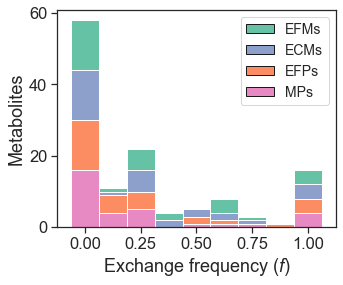

In [54]:
sns.set(style='ticks', font_scale=1.5)

if model_id == 'e_coli_core':
    f = plt.figure()

    df = frac_df

    ax = sns.histplot(data=df, x='fraction', hue='pathway', multiple='stack', bins=9, binrange=[-0.0625, 1.0625], palette=pathway_palette, ec='k', alpha=1)

#     plt.title(model_id, weight='bold')
    plt.ylabel('Metabolites')
    plt.xlabel('Exchange frequency ($f$)')

    xlim = -0.125, 1.125
    plt.xlim(xlim)

    ax.legend(ax.get_legend().legendHandles, ['EFMs', 'ECMs', 'EFPs', 'MPs'], fontsize=14)

    f.set_size_inches(5, 4)
    f.savefig(join(plot_dir, 'exchange_frequencies_dist_' + model_id + '.svg'), bbox_inches='tight')

In [55]:
sns.set(font_scale=1.5, style='ticks')

if model_id.startswith('iIT341'):
    f = plt.figure()

    df = frac_df

    ax = sns.histplot(data=df, x='fraction', hue='pathway', multiple='stack', bins=9, binrange=[-0.0625, 1.0625], palette=pathway_palette, ec='k', alpha=1)

#     plt.title(model_id, weight='bold')
    plt.ylabel('Metabolites')
    plt.xlabel('Exchange frequency ($f$)')

    xlim = -0.125, 1.125
    plt.xlim(xlim)

    ax.legend(ax.get_legend().legendHandles, ['ECMs', 'EFPs', 'MPs'], fontsize=14)

    f.set_size_inches(5, 4)
    f.savefig(join(plot_dir, 'exchange_frequencies_dist_' + model_id + '.svg'), bbox_inches='tight')

c:\Users\ylwe\.conda\envs\unbiased_analysis\lib\site-packages\seaborn\distributions.py:565: MatplotlibDeprecationWarning: Saw kwargs ['ec', 'edgecolor'] which are all aliases for 'edgecolor'.  Kept value from 'edgecolor'.  Passing multiple aliases for the same property will raise a TypeError in 3.3.
  artists = plot_func(
c:\Users\ylwe\.conda\envs\unbiased_analysis\lib\site-packages\seaborn\distributions.py:565: MatplotlibDeprecationWarning: Saw kwargs ['ec', 'edgecolor'] which are all aliases for 'edgecolor'.  Kept value from 'edgecolor'.  Passing multiple aliases for the same property will raise a TypeError in 3.3.
  artists = plot_func(
c:\Users\ylwe\.conda\envs\unbiased_analysis\lib\site-packages\seaborn\distributions.py:565: MatplotlibDeprecationWarning: Saw kwargs ['ec', 'edgecolor'] which are all aliases for 'edgecolor'.  Kept value from 'edgecolor'.  Passing multiple aliases for the same property will raise a TypeError in 3.3.
  artists = plot_func(
c:\Users\ylwe\.conda\envs\un

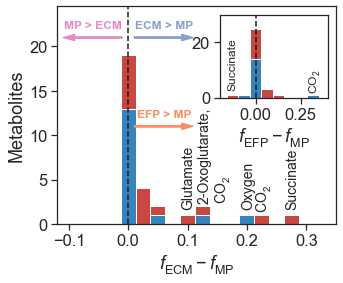

In [56]:
sns.set(style='ticks', font_scale=1.5)

if model_id == 'e_coli_core':
    f = plt.figure()

    df = diff_df.sort_values(by='ecm_difference').reset_index(drop=True)

    ax = sns.histplot(data=df, x='ecm_difference', hue='direction', multiple='stack', palette=[cmap[-1], cmap[0]], bins=12, binrange=[-0.0125, 0.2875], ec='k', alpha=1)

#     plt.title(model_id, weight='bold')
    plt.ylabel('Metabolites')
    plt.xlabel('$f_\mathrm{ECM}-f_\mathrm{MP}$')

    plt.xlim(-0.12, 0.35)

    ylim = 0, 24.5
    plt.ylim(ylim)
    plt.plot([0, 0], ylim, c='k', ls='--')

    c = pathway_palette['efp']
    plt.arrow(0.01, 11, 0.08, 0, color=c, width=0.2, head_width=0.75, head_length=0.02)
    plt.text(0.06, 12, 'EFP > MP', ha='center', fontsize=12, weight='bold', color=c)
    
    c = pathway_palette['ecm']
    plt.arrow(0.01, 21, 0.08, 0, color=c, width=0.2, head_width=0.75, head_length=0.02)
    plt.text(0.06, 22, 'ECM > MP', ha='center', fontsize=12, weight='bold', color=c)

    c = pathway_palette['mp']
    plt.arrow(-0.01, 21, -0.08, 0, color=c, width=0.2, head_width=0.75, head_length=0.02)
    plt.text(-0.06, 22, 'MP > ECM', ha='center', fontsize=12, weight='bold', color=c)
    

    plt.text(0.276, 2, df.metabolite.iloc[-1], rotation=90, fontsize=14, ha='center')
    plt.text(0.23, 2, df.metabolite.iloc[-2], rotation=90, fontsize=14, ha='center')
    plt.text(0.203, 2, df.metabolite.iloc[-3], rotation=90, fontsize=14, ha='center')
    plt.text(0.117, 3, df.metabolite.iloc[-4] + ',\n' + df.metabolite.iloc[-5], rotation=90, fontsize=14, ha='left')
    plt.text(0.101, 2, df.metabolite.iloc[-6][2:], rotation=90, fontsize=14, ha='center')

    ax.legend(reversed(ax.get_legend().legendHandles), ['Uptake', 'Secretion'], fontsize=14).set_visible(False)

    # Inset
    axi = inset_axes(ax, width=1.5, height=1.15, bbox_to_anchor=(1, 1, 0, 0), bbox_transform=ax.transAxes)

    df = diff_df.sort_values(by='efp_difference').reset_index(drop=True)

    sns.histplot(ax=axi, data=df, x='efp_difference', hue='direction', multiple='stack', palette=[cmap[-1], cmap[0]], ec='k', alpha=1, bins=9, binrange=[-0.225, 0.35])

    xlim = -0.2, 0.4
    plt.xlim(xlim)
    
    ylim = 0, 30
    plt.ylim(ylim)
#     axi.set_yticks(np.arange(0, 30, 15))
    plt.plot([0, 0], ylim, c='k', ls='--')

    axi.legend().set_visible(False)
    axi.set_xlabel('$f_\mathrm{EFP}-f_\mathrm{MP}$')
    axi.set_ylabel('')

    plt.text(0.33, 3.5, df.metabolite.iloc[-1], rotation=90, fontsize=12, ha='center')
    plt.text(-0.13, 3.5, df.metabolite.iloc[0], rotation=90, fontsize=12, ha='center')
    
    f.set_size_inches(5, 4)
    f.savefig(join(plot_dir, 'exchange_frequencies_diff_dist_' + model_id + '.svg'), bbox_inches='tight')

In [57]:
sns.set(style='ticks', font_scale=1.5)

if model_id.startswith('iIT341'):
    f = plt.figure()

    df = diff_df.sort_values(by='ecm_difference').reset_index(drop=True)

    ax = sns.histplot(data=df, x='ecm_difference', hue='direction', multiple='stack', palette=[cmap[-1], cmap[0]], bins=17, binrange=[-0.175, 0.675], ec='k', alpha=1)

    plt.ylabel('Metabolites')
    plt.xlabel('$f_\mathrm{ECM}-f_\mathrm{MP}$')

    plt.xlim(-0.25, 0.7)
    plt.xticks(np.arange(-0.2, 0.7, 0.2))
    
    ylim = 0, 79
    plt.ylim(ylim)
    plt.plot([0, 0], ylim, c='k', ls='--')

    plt.text(-0.145, 5, df.metabolite[0] + ', ' + df.metabolite[1].lower(), rotation=90, fontsize=14, ha='center')
    plt.text(0.106, 8, df.metabolite.iloc[-7] + ', ' + df.metabolite.iloc[-8].lower() + ', ' + df.metabolite.iloc[-9].lower() + ', ' + df.metabolite.iloc[-10], rotation=90, fontsize=14, ha='center')
    plt.text(0.158, 6, df.metabolite.iloc[-5][2:] + ', ' + df.metabolite.iloc[-6][2:].lower() + ', ' + df.metabolite.iloc[-7].lower(), rotation=90, fontsize=14, ha='center')
    plt.text(0.21, 4, 'CO$_\mathrm{2}$', rotation=90, fontsize=14, ha='center')
    plt.text(0.235, 5, df.metabolite.iloc[-2] + ',\n' + df.metabolite.iloc[-3].lower(), rotation=90, fontsize=14, ha='left')
    plt.text(0.655, 4, df.metabolite.iloc[-1][2:], rotation=90, fontsize=14, ha='center')

    ax.legend(reversed(ax.get_legend().legendHandles), ['Uptake', 'Secretion'], fontsize=14).set_visible(False)
    
    # Inset
    axi = inset_axes(ax, width=1.5, height=1.15, bbox_to_anchor=(1, 1, 0, 0), bbox_transform=ax.transAxes)

    df = diff_df.sort_values(by='efp_difference').reset_index(drop=True)

    sns.histplot(ax=axi, data=df, x='efp_difference', hue='direction', multiple='stack', palette=[cmap[-1], cmap[0]], ec='k', alpha=1, bins=11, binrange=[-0.1834, 0.1834])

    xlim = -0.2, 0.2
    plt.xlim(xlim)
    axi.set_xticks(np.arange(-0.15, 0.3, 0.15))
    
    ylim = 0, 75
    plt.ylim(ylim)
#     axi.set_yticks(np.arange(0, 80, 50))
    plt.plot([0, 0], ylim, c='k', ls='--')

    axi.legend().set_visible(False)
    axi.set_xlabel('$f_\mathrm{EFP}-f_\mathrm{MP}$')
    axi.set_ylabel('')

    plt.text(0.172, 7, df.metabolite.iloc[-1], rotation=90, fontsize=12, ha='center')
    plt.text(0.1175, 8.5, 'H$_\mathrm{2}$CO$_\mathrm{3}$', rotation=90, fontsize=12, ha='center')
    plt.text(-0.14, 7, df.metabolite.iloc[0], rotation=90, fontsize=12, ha='center')
    plt.text(-0.1, 8, df.metabolite.iloc[1], rotation=90, fontsize=12, ha='center')

    f.set_size_inches(5, 4)
    f.savefig(join(plot_dir, 'frequency_difference_' + model_id + '.svg'), bbox_inches='tight')

In [58]:
# Set minimal growth requirement in model

min_growth = 1e-4

if model_id == 'e_coli_core':
    model.reactions.BIOMASS_Ecoli_core_w_GAM.lower_bound = min_growth
elif model_id.startswith('iIT341'):
    model.reactions.BIOMASS_HP_published.lower_bound = min_growth

In [59]:
# Load samples from PTA or sample using optGP

load_samples = True

n = int(1e4)

if load_samples:
    # Load uniform flux samples from PTA
    if model_id == 'e_coli_core':
        df = pd.read_csv('results/sampling/flux_samples_e_coli_core.csv', index_col=0)
    #     df = pd.read_csv('results/sampling/flux_samples_e_coli_core_no_ATPM.csv', index_col=0)
    elif model_id == 'iIT341_ecm_minII':
        df = pd.read_csv('results/sampling/flux_samples_iIT341.csv', index_col=0)
else:
    # Sample with optGP
    df = cobra.sampling.sample(model, n)
    if model_id == 'e_coli_core':
        df.to_csv('results/sampling/flux_samples_e_coli_core_optgp.csv')
    elif model_id.startswith('iIT341'):
        df.to_csv('results/sampling/flux_samples_iIT341_optgp.csv')
        
sample_df = df
sample_df

PFK         PFL         PGI         PGK         PGL       ACALD  \
0      940.911469  264.807560  475.559932 -963.385354   15.442958 -533.512128   
1      670.084876  123.824761  436.337508 -981.478334   66.118949 -339.906833   
2      717.538381  103.183083  376.377283 -914.276006   98.875549 -285.400414   
3      484.567528  118.288519  370.920394 -807.259865   43.313310  -82.350701   
4      753.517131    4.198283  398.191050 -888.202509   58.747924 -116.877556   
...           ...         ...         ...         ...         ...         ...   
99995  448.414130  258.066391  383.697801 -838.744211   48.836375 -173.054722   
99996  481.529531  334.427075  260.210848 -759.523806  150.591668 -162.803154   
99997  729.825615  328.409025  385.793087 -929.145126  101.909292 -326.873860   
99998  456.390398  433.099026  372.926082 -932.470387  115.713552 -365.336489   
99999  621.045386  230.109701  426.751014 -928.758572   52.919828 -340.034146   

          AKGt2r         PGM      PIt2r      ALCD2x  ...       MALS  \
0      -1.041527 -954.420683  22.044341 -346.793736  ...  72.366226   
1     -19.862873 -980.550159   2.282404 -326.821087  ...  30.175473   
2      -3.554438 -912.099416   5.352286  -52.350059  ...  29.234610   
3     -41.389351 -802.755314  11.076798  -76.805567  ...  56.976059   
4     -16.970483 -884.148412   9.969121 -115.105552  ...  33.443654   
...          ...         ...        ...         ...  ...        ...   
99995 -25.975233 -832.060120  16.436341  -88.123985  ...  80.638186   
99996 -12.297029 -751.616289  19.444775 -131.620077  ...   6.633336   
99997  -5.124593 -920.967550  20.108854 -194.155210  ...  47.877430   
99998  -9.929830 -928.319876  10.206206 -271.060297  ...  17.187252   
99999  -5.044195 -920.146297  21.177793 -157.636641  ...  17.940837   

            MALt2_2         MDH         ME1         ME2      NADH16  \
0     -6.362170e-14  111.533505   17.214494   41.678521  765.269060   
1     -5.022217e-14 -111.172690   78.452946  126.935260  785.470714   
2     -1.301646e-13 -301.709685  191.401149   43.708633  921.267017   
3      7.369841e-14 -214.358101  220.500968   80.494940  923.020914   
4     -1.493894e-13 -207.188903   60.847818   36.234741  822.635647   
...             ...         ...         ...         ...         ...   
99995 -2.216164e-13 -241.566769  205.627362  130.505508  966.382565   
99996 -1.380992e-13  -64.135278   82.699914   13.651193  613.167537   
99997 -1.630588e-13 -136.725934  155.228877   67.474390  816.403908   
99998  1.412872e-14 -227.927083  152.823068  123.640809  736.152609   
99999 -3.147482e-13 -125.054774   79.245556   79.994588  919.271490   

          NADTRHD        NH4t         O2t         PDH  
0       30.203312   37.525785  431.664677  519.920827  
1      573.610955   33.149320  424.755379  426.522749  
2      307.029294   74.895876  412.716252  363.629525  
3      218.855362   30.631193  476.341331  332.900916  
4      163.196377  129.539745  339.542825  337.219289  
...           ...         ...         ...         ...  
99995  206.293572  126.266405  490.155240  256.831369  
99996  342.610175   32.957539  319.375015    1.021309  
99997  580.347633   54.866761  427.251905  247.204587  
99998  928.641378   28.468849  383.751075  306.042713  
99999  459.110969   87.668540  467.758011  465.654956  

[100000 rows x 95 columns]

In [63]:
# Keep boundary reactions with non-zero flux in at least one sample
df = sample_df

df = df[[r.id for r in model.boundary]]

tol = 1e-6
s = (df.abs() > tol).any()
df = df[s[s].index]

df.columns = [x[3:] for x in df.columns]

sample_df = df
sample_df

ac_e     acald_e      akg_e       co2_e      etoh_e       for_e  \
0       31.544612  186.718392   1.041527  662.841152  346.793736  264.807560   
1       29.429385   13.085746  19.862873  623.609814  326.821087  123.824761   
2       28.258608  233.050354   3.554438  381.216010   52.350059  103.183083   
3      175.469716    5.545134  41.389351  409.777690   76.805567  118.288519   
4       10.358311    1.772004  16.970483  250.056208  115.105552    4.198283   
...           ...         ...        ...         ...         ...         ...   
99995   15.196787   84.930737  25.975233  327.538368   88.123985  258.066391   
99996   56.863151   31.183076  12.297029  228.321643  131.620077  334.427075   
99997   37.334979  132.718650   5.124593  436.528161  194.155210  328.409025   
99998  284.807552   94.276192   9.929830  466.110344  271.060297  433.099026   
99999  213.518999  182.397505   5.044195  541.754998  157.636641  230.109701   

         glc__D_e    glu__L_e         h_e       h2o_e    lac__D_e       nh4_e  \
0     -492.231338    4.850279  641.682345  531.549973   38.841091  -37.525785   
1     -502.583647   29.766197  706.021786  477.703306  329.754559  -33.149320   
2     -475.551094   66.962382  838.834041  707.358678  168.097788  -74.895876   
3     -414.850972   14.212467  836.178528  550.075590  250.252793  -30.631193   
4     -457.494515  114.762888  939.451573  682.477982  163.271792 -129.539745   
...           ...         ...         ...         ...         ...         ...   
99995 -433.450111  101.903429  943.426246  712.541245   57.319228 -126.266405   
99996 -411.886100    4.135274  945.313192  293.665194  247.909306  -32.957539   
99997 -488.822969   25.060155  933.685823  493.958473  177.662583  -54.866761   
99998 -489.208387   13.340570  989.746357  273.594700  154.051151  -28.468849   
99999 -480.851000   56.277485  845.880097  615.209322   78.695195  -87.668540   

             o2_e       pi_e       pyr_e      succ_e  
0     -431.664677 -22.044341  145.638036   14.429675  
1     -424.755379  -2.282404   42.964884   34.172038  
2     -412.716252  -5.352286   84.646612  142.214113  
3     -476.341331 -11.076798   47.370147   36.595895  
4     -339.542825  -9.969121   84.845645  179.474525  
...           ...        ...         ...         ...  
99995 -490.155240 -16.436341  102.187108   82.635911  
99996 -319.375015 -19.444775   83.974231   41.621105  
99997 -427.251905 -20.108854   82.538823   68.858534  
99998 -383.751075 -10.206206    7.994692    3.799280  
99999 -467.758011 -21.177793   47.594485   18.917784  

[100000 rows x 16 columns]

In [64]:
# Flux variability analysis

fva_bounds = {x[3:]: b for x, b in mpt.fva(mpt.create_lp(model)).items() if x in set(r.id for r in model.boundary)}

fva_bounds

c:\users\ovoy\envs\base\lib\site-packages\ipykernel_launcher.py:3: DeprecationWarning: Deprecated, pass a TempConstr or use Model.addLConstr
  This is separate from the ipykernel package so we can avoid doing imports until


{'ac_e': (0.0, 666.6658724066666),
 'acald_e': (0.0, 999.99874598),
 'akg_e': (0.0, 333.33293620333336),
 'co2_e': (-333.3326471500002, 1000.0),
 'etoh_e': (0.0, 999.9987459799999),
 'for_e': (0.0, 999.9979940000004),
 'fru_e': (0.0, 0.0),
 'fum_e': (0.0, 0.0),
 'glc__D_e': (-650.6442719226957, -0.0010909319444444444),
 'gln__L_e': (0.0, 0.0),
 'glu__L_e': (0.0, 399.999392312),
 'h_e': (0.002006000000392305, 1000.0),
 'h2o_e': (-499.9981529500001, 1000.0),
 'lac__D_e': (0.0, 999.9979939999998),
 'mal__L_e': (0.0, 0.0),
 'nh4_e': (-399.9999375919999, -0.0005452799999829949),
 'o2_e': (-500.0, 0.0),
 'pi_e': (-125.62182783687513, -0.00036786999999094405),
 'pyr_e': (0.0, 999.9979940000003),
 'succ_e': (0.0, 499.99899699999986)}

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15


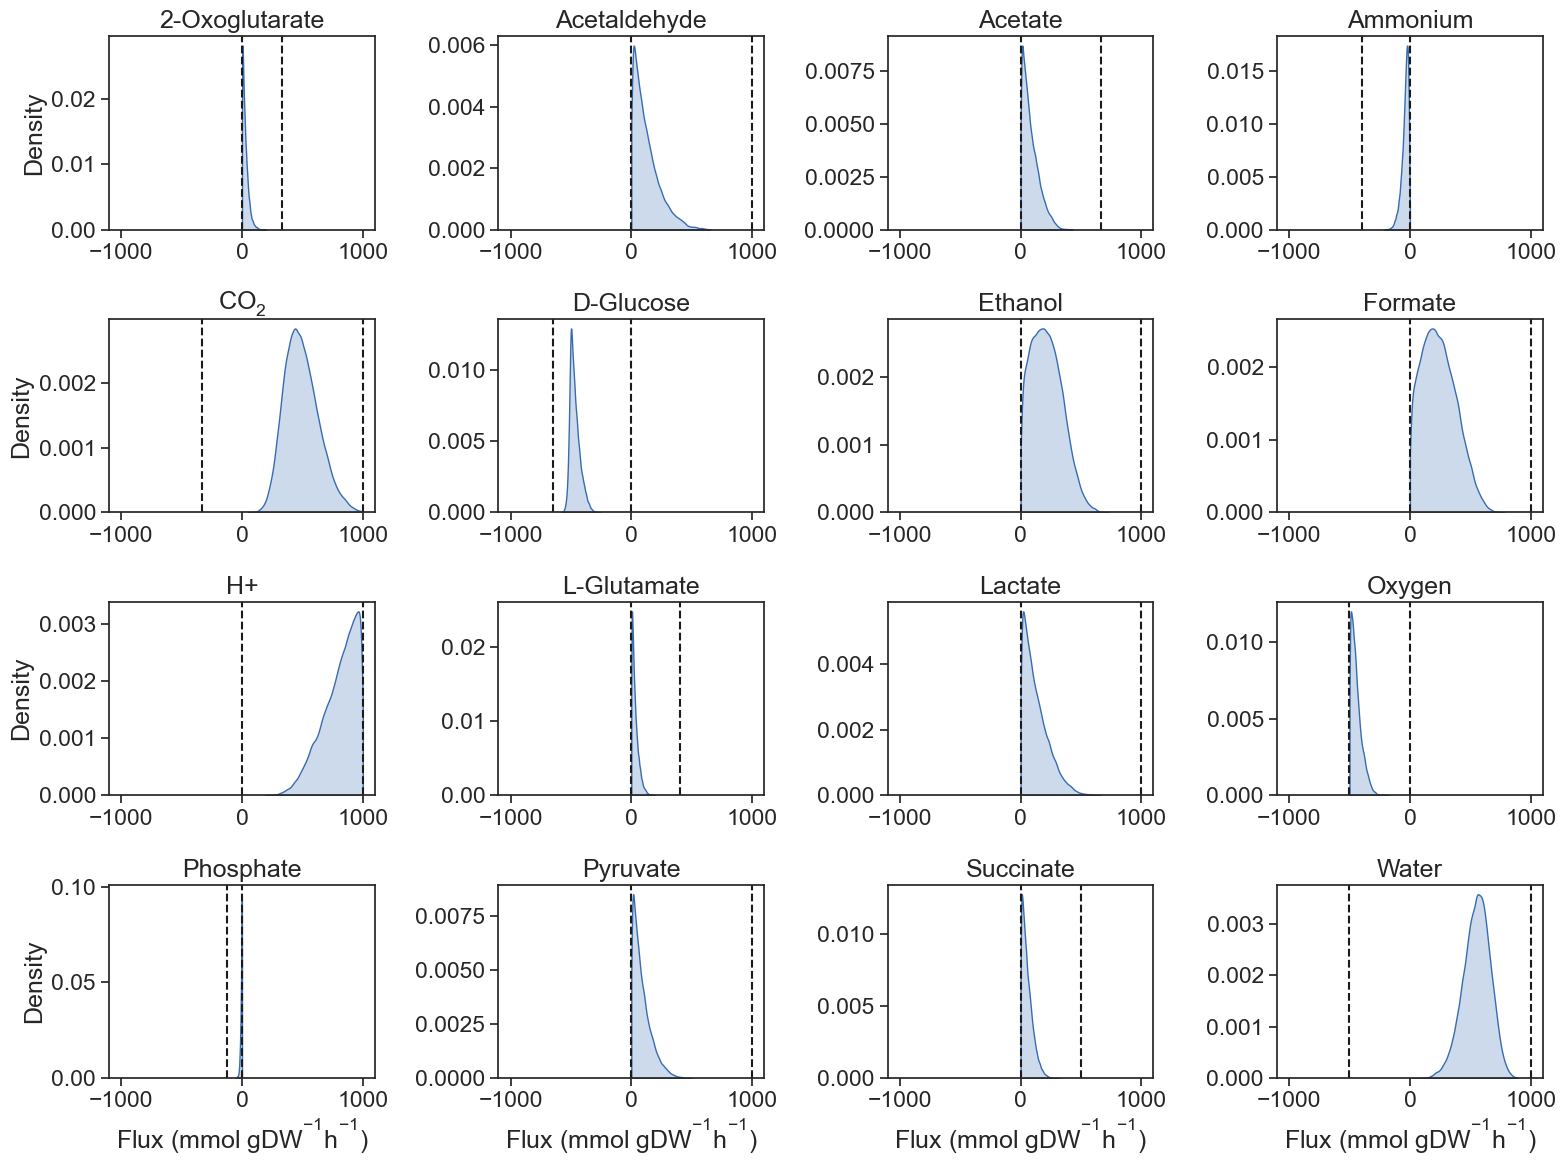

In [65]:
if model_id == 'e_coli_core':
    sns.set(style='ticks', font_scale=1.5)
    f = plt.figure()

    df = sample_df

    bound = 1000
    n = 4
    m = int(np.ceil(len(df.columns) / n))

    df = df.sort_index(axis=1, ascending=True, key=lambda s: pd.Series(met_names[y] for y in s))

    for i, x in enumerate(df.columns):
        print(i)
        plt.subplot(m, n, i + 1)

        ax = sns.kdeplot(df[x], cut=0, fill=True, color='#386cb0')

        plt.title(met_names[x])
        if i % n:
            plt.ylabel('')
        if i >= n * (m - 1):    
            plt.xlabel('Flux (mmol gDW$^{-1}$h$^{-1}$)')
        else:
            plt.xlabel('')
        plt.xlim(-bound * 1.1, bound * 1.1)
        plt.ylim(plt.ylim())

        lb, ub = fva_bounds[x]
        plt.plot([lb, lb], plt.ylim(), ls='--', c='k')
        plt.plot([ub, ub], plt.ylim(), ls='--', c='k')

#         ax.text(-0.34, 1.05, string.ascii_uppercase[i], transform=ax.transAxes, size=20, weight='bold')

    f.set_size_inches(4 * n, 3 * m)
    plt.tight_layout()
    
    fname = 'sampling_' + model_id
    fname += '_pta'  if load_samples else '_optgp'
    
    f.savefig(join(plot_dir, fname + '.pdf'), bbox_inches='tight')

In [67]:
if model_id.startswith('iIT341'):
    sns.set(style='ticks', font_scale=1.5)
    f = plt.figure()

    df = sample_df

    bound = 1000
    n = 5
    m = int(np.ceil(len(df.columns) / n))
    
    df = df.sort_index(axis=1, ascending=True, key=lambda s: pd.Series(met_names[y] for y in s))

    for i, x in enumerate(df.columns):
        print(i)
        plt.subplot(m, n, i + 1)
        
        ax = sns.kdeplot(df[x], cut=0, fill=True, color='#386cb0')

        plt.title(met_names[x])
        if i % n:
            plt.ylabel('')
        if i >= n * (m - 1):    
            plt.xlabel('Flux (mmol gDW$^{-1}$h$^{-1}$)')
        else:
            plt.xlabel('')
        plt.xlim(-bound * 1.1, bound * 1.1)
        plt.ylim(plt.ylim())

        lb, ub = fva_bounds[x]
        plt.plot([lb, lb], plt.ylim(), ls='--', c='k')
        plt.plot([ub, ub], plt.ylim(), ls='--', c='k')

#         ax.text(-0.34, 1.05, string.ascii_uppercase[i], transform=ax.transAxes, size=20, weight='bold')

    f.set_size_inches(4 * n, 3 * m)
    plt.tight_layout()
    
    fname = 'sampling_' + model_id
    fname += '_pta'  if load_samples else '_optgp'
    
    f.savefig(join(plot_dir, fname + '.pdf'), bbox_inches='tight')

In [83]:
if model_id == 'e_coli_core':

    model = cobra.io.read_sbml_model('models/' + model_id + '.xml')

    bound = 1000
    min_growth = 1e-4

    if model_id == 'e_coli_core':
        model.reactions.BIOMASS_Ecoli_core_w_GAM.lower_bound = min_growth
    elif model_id == 'iIT341_ecm_minII':
        model.reactions.BIOMASS_HP_published.lower_bound = min_growth

    df = mp_df
    df = df[sorted(df.columns)]

    # # Turn off boundary reactions that are not part of any MPs
    # for r in model.boundary:
    #     if r.id[3:] not in df.columns:
    #         r.bounds = 0, 0

    # Get FVA bounds and sample the flux space for each MP
    mp_samples = []
    mp_bounds = []
    for i, row in df.iterrows():
        print(i)
        for r in model.boundary:
            x = r.id[3:]
            if x not in row or not row[x]:
                r.bounds = 0, 0
            elif row[x] > 0:
                r.bounds = 0, bound
            elif row[x] < 0:
                r.bounds = -bound, 0

        mp_samples.append(cobra.sampling.sample(model, int(1e3)))

#         fva_df = cobra.flux_analysis.flux_variability_analysis(model, reaction_list=model.boundary, fraction_of_optimum=0)
#         mp_bounds.append({i[3:]: (row.minimum, row.maximum) for i, row in fva_df.iterrows()})
        d = {x[3:]: b for x, b in mpt.fva(mpt.create_lp(model)).items() if x in set(r.id for r in model.boundary)}
        mp_bounds.append(d)

    #     if i == 2:
    #         break

    mp_samples, mp_bounds

0
Read LP format model from file C:\NMBU\TEMP\tmp63gwbv60.lp
Reading time = 0.01 seconds
: 72 rows, 190 columns, 720 nonzeros
1
Read LP format model from file C:\NMBU\TEMP\tmpc01ex548.lp
Reading time = 0.01 seconds
: 72 rows, 190 columns, 720 nonzeros


c:\users\ovoy\envs\base\lib\site-packages\ipykernel_launcher.py:39: DeprecationWarning: Deprecated, pass a TempConstr or use Model.addLConstr


2
Read LP format model from file C:\NMBU\TEMP\tmpw798yxsw.lp
Reading time = 0.01 seconds
: 72 rows, 190 columns, 720 nonzeros
3
Read LP format model from file C:\NMBU\TEMP\tmpr304uhdq.lp
Reading time = 0.01 seconds
: 72 rows, 190 columns, 720 nonzeros
4
Read LP format model from file C:\NMBU\TEMP\tmpxjv7ds3m.lp
Reading time = 0.04 seconds
: 72 rows, 190 columns, 720 nonzeros
5
Read LP format model from file C:\NMBU\TEMP\tmpyg6wamw6.lp
Reading time = 0.05 seconds
: 72 rows, 190 columns, 720 nonzeros
6
Read LP format model from file C:\NMBU\TEMP\tmp_jllpy_9.lp
Reading time = 0.03 seconds
: 72 rows, 190 columns, 720 nonzeros
7
Read LP format model from file C:\NMBU\TEMP\tmpj1e94v9t.lp
Reading time = 0.05 seconds
: 72 rows, 190 columns, 720 nonzeros
8
Read LP format model from file C:\NMBU\TEMP\tmplac3elcd.lp
Reading time = 0.02 seconds
: 72 rows, 190 columns, 720 nonzeros
9
Read LP format model from file C:\NMBU\TEMP\tmph_k9mvmu.lp
Reading time = 0.01 seconds
: 72 rows, 190 columns, 720 n

In [84]:
if model_id == 'e_coli_core':
    sns.set(style='ticks', font_scale=2.5)
    f = plt.figure()

    tol = 1e-6
    min_growth = 1e-4

    mp_df = mp_df.sort_index(axis=1, ascending=True, key=lambda s: pd.Series(met_names[y] for y in s))
    m, n = mp_df.shape

    for i, df in enumerate(mp_samples):
    #     if i < len(mp_df) - 2:
    #         continue

        df = df[[r.id for r in model.boundary]]
        s = (df.abs() > tol).any()
        df = df[s[s].index]
        df.columns = [x[3:] for x in df.columns]

        for j, x in enumerate(mp_df.columns):

            ax = plt.subplot(m + 2, n, i * n + j + 1)
            plt.box(False)
            ax.set_xticks([])

            if i == 0:
                ax.text(0.5, 0, met_names[x], fontsize=64, transform=ax.transAxes, ha='center', va='bottom', rotation=90)
            
            elif x in df.columns:
                plt.box(True)

                ax = sns.kdeplot(df[x], cut=0, fill=True, color='#386cb0', alpha=1)

    #             ax.set_xticklabels([-1, 0, 1])
                plt.xlabel('')
                ax.set_xticks([-1000, 0, 1000])
                ax.set_xticklabels([-1, 0, 1])
                plt.ylabel('')
                plt.ylim(plt.ylim())

                lb, ub = mp_bounds[i][x]
                plt.plot([lb, lb], plt.ylim(), ls='--', c='k')
                plt.plot([ub, ub], plt.ylim(), ls='--', c='k')

                ax.spines[['right', 'top', 'left']].set_visible(False)

            plt.yticks([])
            plt.xlim(-bound * 1.1, bound * 1.1)
    
    ax = plt.subplot(m + 2, 1, m + 1)
    ax.text(0.5, 0.5, 'Flux (mol gDW$^{-1}$h$^{-1}$)', fontsize=64, transform=ax.transAxes, ha='center', va='center')
    plt.box(False)
    ax.set_xticks([])
    ax.set_yticks([])
    
    f.set_size_inches(4 * n, 2.5 * (m + 1))
    plt.tight_layout()
    f.savefig(join(plot_dir, 'sampling_mp_' + model_id + '_optgp.pdf'), bbox_inches='tight', dpi=300)